# keras/TF model
<pre>
 Copyright (c) 2024 Aydin Hamedi
 
 This software is released under the MIT License.
 https://opensource.org/licenses/MIT
</pre>

## Pre Conf

In [1]:
CPU_only = False  # True to Force TF to use the cpu

## Pylibs

In [2]:
import io
import os
import time

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
if CPU_only:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import cv2
import glob
import keras
import random
import shutil
import pickle
import datetime
import subprocess
import gpu_control
import numpy as np
from tqdm import tqdm
import seaborn as sns

# import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import *  # noqa: F403
from adabelief_tf import AdaBeliefOptimizer  # noqa: F401

# from tensorflow_addons.optimizers import Yogi
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard, LambdaCallback
from keras.utils import to_categorical
from keras.callbacks import (
    ModelCheckpoint,
    Callback,
    LearningRateScheduler,
    ReduceLROnPlateau,
)
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (
    Dense,
    Dropout,
    BatchNormalization,
    Input,
    GlobalAveragePooling2D,
    concatenate,
)

# Utils
from Utils.one_cycle import OneCycleLr
from Utils.lr_find import LrFinder
from Utils.Grad_cam import make_gradcam_heatmap
from Utils.print_color_V2_NEW import print_Color_V2
from Utils.print_color_V1_OLD import print_Color
from Utils.Timeout_input import TimeoutInput
from Utils.Other import *  # noqa: F403

# Other
tf.get_logger().setLevel("ERROR")
physical_devices = tf.config.list_physical_devices("GPU")
for gpu_instance in physical_devices:
    tf.config.experimental.set_memory_growth(gpu_instance, True)

## Prep

In [3]:
from numba.cuda.cudadrv import enums
from numba import cuda

device = cuda.get_current_device()
attribs = [name.replace("CU_DEVICE_ATTRIBUTE_", "") for name in dir(enums) if name.startswith("CU_DEVICE_ATTRIBUTE_")]

with open("GPU_Info.txt", "w") as f:
    for attr in attribs:
        f.write(f"{attr} = {getattr(device, attr)}\n")

## Conf


### Data processing conf

In [4]:
# Directory paths# Directory paths for training, test and validation image data
train_dir = "Database\\Train\\Data\\train"
test_dir = "Database\\Train\\Data\\test"
validation_dir = "Database\\Train\\Data\\val"
img_res = [224, 224, 3]
# img_res = [324, 324, 3]
# img_res = [224, 224, 3]
# img_res = [384, 384, 3] # Very slow needs >=24Gb Vram for batch size of 1 (NR!)
interpolation_order_IFG = 2
categorical_IMP = True
Make_EV_DATA = False
R_fill_mode = True
add_img_grain = True
Save_TS = True
Img_Data_type = "float16"  # float32 / float16
Use_SMOTE = False  # (⚠️Beta⚠️)
ADBD = 0
OP_HDC = False
SL_EX = "_V1"  # _NONOM_V1 | _V1 | _SDNP_V1
LNTS = 0
Debug_OUT = False
RANGE_NOM = True  # False for 0 to 255 True for 0 to 1 >> use False for models like ConvNeXtXLarge (⚠️deprecated⚠️)
scale_data_NP_M = False  # (⚠️deprecated⚠️)

### Training 

In [5]:
SAVE_TYPE = "H5"
Use_mixed_float16 = True
# Other
if Use_mixed_float16:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
else:
    tf.keras.mixed_precision.set_global_policy("float32")

print(tf.keras.mixed_precision.global_policy())

<Policy "mixed_float16">


## data processing 


In [6]:
# Z_SCORE_normalize
def Z_SCORE_normalize(arr):
    arr = arr.astype(Img_Data_type)
    mean = np.mean(arr)
    std_dev = np.std(arr)
    arr = (arr - mean) / std_dev
    return arr


# normalize_TO_RANGE
def normalize_TO_RANGE(arr, min_val, max_val):
    arr = arr.astype(Img_Data_type)
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    arr = arr * (max_val - min_val) + min_val
    return arr


# scale_data
def scale_data_NP(data):
    if scale_data_NP_M:
        data = data.astype(Img_Data_type)
        data = (data - 127.5) / 127.5
        return data
    else:
        return data / 255


# add_image_grain
def add_image_grain(image, intensity=0.01):
    # Generate random noise array
    noise = np.random.randint(0, 255, size=image.shape, dtype=np.uint8)

    # Scale the noise array
    scaled_noise = (noise * intensity).astype(np.float32 if Img_Data_type == "float32" else "float16")
    # Add the noise to the image
    noisy_image = cv2.add(image, scaled_noise)

    return noisy_image


# apply_clahe_rgb_array
def apply_clahe_rgb_array(images, clip_limit=1.8, tile_grid_size=(8, 8)):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Iterate over each image in the array
    for i in range(len(images)):
        # Split the image into color channels
        b, g, r = cv2.split(images[i])

        # Convert the channels to the appropriate format
        b = cv2.convertScaleAbs(b)
        g = cv2.convertScaleAbs(g)
        r = cv2.convertScaleAbs(r)

        # Apply adaptive histogram equalization to each channel
        equalized_b = clahe.apply(b)
        equalized_g = clahe.apply(g)
        equalized_r = clahe.apply(r)

        # Merge the equalized channels back into an image
        equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))

        # Replace the original image with the equalized image in the array
        images[i] = equalized_image

    return images


# noise_func
def noise_func(image):
    noise_type = np.random.choice(["L1", "L2", "L3", "none"])
    new_image = np.copy(image)

    if noise_type == "L3":
        intensityL2 = random.uniform(-0.05, 0.05)
        intensityL1 = random.uniform(-0.04, 0.04)
    else:
        intensityL2 = random.uniform(-0.06, 0.06)
        intensityL1 = random.uniform(-0.04, 0.04)

    block_size_L1 = random.randint(16, 32)
    block_size_L2 = random.randint(32, 64)

    if noise_type == "L2" or noise_type == "L3":
        for i in range(0, image.shape[0], block_size_L2):
            for j in range(0, image.shape[1], block_size_L2):
                block = image[i : i + block_size_L2, j : j + block_size_L2]
                block = (np.random.rand() * intensityL2 + 1) * block
                new_image[i : i + block_size_L2, j : j + block_size_L2] = block
        image = new_image

    if noise_type == "L1" or noise_type == "L3":
        for i in range(0, image.shape[0], block_size_L1):
            for j in range(0, image.shape[1], block_size_L1):
                block = image[i : i + block_size_L1, j : j + block_size_L1]
                block = (np.random.rand() * intensityL1 + 1) * block
                new_image[i : i + block_size_L1, j : j + block_size_L1] = block

    if add_img_grain:
        intensity = random.uniform(0, 0.045)  # Random intensity between 0 and 0.026
        new_image = add_image_grain(new_image, intensity=intensity)
    return new_image


# shuffle_data
def shuffle_data(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    return x, y


# save_images_to_dir
def save_images_to_dir(images, labels, dir_path):
    # create the directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    # iterate over the images and labels
    for i, (image, label) in enumerate(zip(images, labels)):
        # get the class label
        class_label = np.argmax(label)
        # create the file path
        file_path = os.path.join(dir_path, f"image_{i}_class_{class_label}.png")
        # save the image to the file path
        plt.imsave(file_path, image.squeeze())
    # compress the directory
    shutil.make_archive(dir_path, "gztar", dir_path)
    # remove the original directory
    shutil.rmtree(dir_path)


# Debug_img_Save
def Debug_img_Save(img, id="DEF"):
    SITD = np.random.choice(img.shape[0], size=400, replace=False)
    S_dir = f"Samples\\Debug\\{id}\\TSR_SUB_400_" + datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
    print_Color(f"~*[Debug] (DPO) Sample dir: ~*{S_dir}", ["red", "green"], advanced_mode=True)
    save_images_to_dir(normalize_TO_RANGE(img[SITD], 0, 1), img[SITD], S_dir)


# Create an ImageDataGenerator for the training set
if OP_HDC:
    print_Color("Using OP_HDC IDG...", ["yellow"])
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=179,
        zoom_range=0.24,
        shear_range=0.22,
        width_shift_range=0.21,
        brightness_range=(0.86, 1.1),
        height_shift_range=0.21,
        channel_shift_range=100,
        featurewise_center=False,
        featurewise_std_normalization=False,
        interpolation_order=interpolation_order_IFG,
        fill_mode="nearest",  # constant
        preprocessing_function=noise_func,
        dtype=Img_Data_type,
    )
else:
    print_Color("Using Def IDG...", ["yellow"])
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=179,
        zoom_range=0.26,
        shear_range=0.25,
        width_shift_range=0.25,
        brightness_range=(0.78, 1.1),
        height_shift_range=0.25,
        channel_shift_range=100,
        featurewise_center=False,
        interpolation_order=interpolation_order_IFG,
        featurewise_std_normalization=False,
        fill_mode="nearest",  # constant
        preprocessing_function=noise_func,
        dtype=Img_Data_type,
    )
train_datagen_SM = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=20,
    zoom_range=0.07,
    shear_range=0.07,
    width_shift_range=0.07,
    brightness_range=(0.99, 1.01),
    height_shift_range=0.07,
    channel_shift_range=0,
    featurewise_center=False,
    interpolation_order=interpolation_order_IFG,
    featurewise_std_normalization=False,
    dtype=Img_Data_type,
)
# Create an iterator for the training set
train_generator_SM = train_datagen_SM.flow_from_directory(
    train_dir,
    target_size=(img_res[0], img_res[1]),
    batch_size=sum([len(files) for r, d, files in os.walk(train_dir)]),
    class_mode="binary",
)
# Create an ImageDataGenerator for the validation set (OP)
if Make_EV_DATA:
    val_datagen = ImageDataGenerator(
        horizontal_flip=False,
        zoom_range=0.01,
        width_shift_range=0.01,
        interpolation_order=interpolation_order_IFG,
        dtype=Img_Data_type,
        height_shift_range=0.01,
    )

    # Create an iterator for the validation set
    val_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_res[0], img_res[1]),
        batch_size=sum([len(files) for r, d, files in os.walk(validation_dir)]),
        class_mode="binary",
        color_mode="rgb",
    )

    # Create an ImageDataGenerator for the test set
    test_datagen = ImageDataGenerator(
        horizontal_flip=False,
        zoom_range=0.01,
        width_shift_range=0.01,
        interpolation_order=interpolation_order_IFG,
        dtype=Img_Data_type,
        height_shift_range=0.01,
    )

    # Create an iterator for the test set
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_res[0], img_res[1]),
        batch_size=sum([len(files) for r, d, files in os.walk(test_dir)]),
        class_mode="binary",
        color_mode="rgb",
    )
# Load all images and labels into memory
print_Color("Loading all images and labels into memory...", ["yellow"])
x_train, y_train = next(iter(train_generator_SM))
if Make_EV_DATA:
    x_val, y_val = next(iter(val_generator))
    x_test, y_test = next(iter(test_generator))
if Debug_OUT:
    Debug_img_Save(x_train, "ST1")  # DEBUG
# fit parameters from data
# train_datagen.fit(x_train)
# to_categorical (TEMP)
if categorical_IMP:
    print_Color("Making categorical data...", ["yellow"])
    y_train = to_categorical(y_train, num_classes=2)
    if Make_EV_DATA:
        y_val = to_categorical(y_val, num_classes=2)
        y_test = to_categorical(y_test, num_classes=2)
# Use_SMOTE
if Use_SMOTE:
    print_Color("SMOTE...", ["yellow"])
    # Convert y_train from one-hot encoding to label encoding
    y_train_label_encoded = np.argmax(y_train, axis=1)

    # Print the original label distribution
    unique, counts = np.unique(y_train_label_encoded, return_counts=True)
    print_Color(
        f"~*- Original label distribution: ~*{dict(zip(unique, counts))}",
        ["normal", "blue"],
        advanced_mode=True,
    )

    # Use SMOTE to oversample the minority class
    smote = SMOTE(random_state=42)
    x_train_res, y_train_res_label_encoded = smote.fit_resample(x_train.reshape(x_train.shape[0], -1), y_train_label_encoded)

    # Print the resampled label distribution
    unique_res, counts_res = np.unique(y_train_res_label_encoded, return_counts=True)
    print_Color(
        f"~*- Resampled label distribution: ~*{dict(zip(unique_res, counts_res))}",
        ["normal", "blue"],
        advanced_mode=True,
    )

    # Reshape x_train_res back to the original x_train shape
    x_train_res = x_train_res.reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[3])

    # Convert y_train_res from label encoding back to one-hot encoding
    y_train_res = to_categorical(y_train_res_label_encoded)

    # Calculate the ratio of two labels after resampling
    pneumonia_count = np.sum(y_train_res[:, 1])
    total_count = y_train_res.shape[0]
    label_ratio_res = pneumonia_count / total_count
    label_ratio_percentage_res = label_ratio_res * 100

    # Replace the original data with the resampled data
    x_train = x_train_res
    y_train = y_train_res

    # Delete the resampled data to free up memory
    del x_train_res, y_train_res_label_encoded, y_train_res
# Generating augmented data
print_Color(
    f"~*Generating augmented data ~*[~*ADBD: ~*{str(ADBD)}~*]~*...",
    ["yellow", "cyan", "green", "red", "cyan", "yellow"],
    advanced_mode=True,
)
if ADBD > 0:
    for i in range(ADBD):
        # ADB_clip_limit Scheduler>>>
        if i == 0:
            ADB_clip_limit = 0.8
        else:
            # V1>>>
            CL_SLM = 2.4
            ADB_clip_limit = max(2 / (i + 1) ** CL_SLM, 0.05)
            # Try it in win graphing calculator copy and paste:
            #  ┌-------------┬--┬---------------┐
            #  │ 𝑦=2/(𝑥+1)^𝑧 ├OR┤ 𝑦=2/(𝑥+1)^2.4 │
            #  └-------------┴--┴---------------┘
            # V2>>>
            # CL_SLM_2 = 1.4
            # CL_SLM_Start_2 = 2
            # ADB_clip_limit = CL_SLM_Start_2/(i+1)**(i+CL_SLM_2)
            # Try it in win graphing calculator copy and paste:
            #  ┌-----------------┬--┬-------------------┐
            #  │ 𝑦=2/(𝑥+1)^(𝑥+𝑉) ├OR┤ 𝑦=2/(𝑥+1)^(𝑥+1.4) │
            #  └-----------------┴--┴-------------------┘
        print(f">   Generating ADB[{i + 1}/{ADBD}]...")
        # prepare an iterators to scale images
        train_iterator = train_datagen.flow(x_train, y_train, batch_size=len(x_train))

        # get augmented data
        x_train_augmented, y_train_augmented = train_iterator.next()
        print(">   ├───Applying adaptive histogram equalization...")
        print(f">   ├───Adaptive histogram equalization clip limit = {round(ADB_clip_limit, 2)}")
        x_train_augmented = np.clip(x_train_augmented, 0, 255)
        if Debug_OUT:
            Debug_img_Save(x_train_augmented, "ST2")  # DEBUG
        # print_Color(f'~*>   |---Grayscale range: ~*Min = {np.min(x_train_augmented)}~* | ~*Max = {np.max(x_train_augmented)}', ['normal', 'blue', 'normal', 'red'], advanced_mode=True)
        x_train_augmented = apply_clahe_rgb_array(x_train_augmented, clip_limit=ADB_clip_limit)  # compensating the image info loss
        print(">   └───Adding the Generated ADB...")
        if Debug_OUT:
            Debug_img_Save(x_train_augmented, "ST3")  # DEBUG
        # append augmented data to original data
        x_train = np.concatenate([x_train, x_train_augmented])
        y_train = np.concatenate([y_train, y_train_augmented])
        # free up memory
        del y_train_augmented
        del x_train_augmented
# normalizing
print_Color("Normalizing image data...", ["yellow"])
if Debug_OUT:
    Debug_img_Save(x_train, "ST4")  # DEBUG
x_train = np.clip(x_train, 0, 255)
if RANGE_NOM:
    x_train = scale_data_NP(x_train)
y_train = np.array(y_train)
if Make_EV_DATA:
    x_test = np.clip(x_test, 0, 255)
    x_val = np.clip(x_val, 0, 255)
    if RANGE_NOM:
        x_val = scale_data_NP(x_val)
    y_val = np.array(y_val)
    if RANGE_NOM:
        x_test = scale_data_NP(x_test)
    y_test = np.array(y_test)
if Debug_OUT:
    Debug_img_Save(x_train, "ST5")  # DEBUG
# Check the data type of image data
print_Color(f"~*Data type: ~*{x_train.dtype}", ["normal", "green"], advanced_mode=True)
# Check the range of image data
print_Color(
    f"~*RGB Range: ~*Min = {np.min(x_train)}~* | ~*Max = {np.max(x_train)}",
    ["normal", "blue", "normal", "red"],
    advanced_mode=True,
)
# Calculate the ratio of two labels
if categorical_IMP:
    label_sums = np.sum(y_train, axis=0)
    label_ratio = label_sums / (np.sum(y_train) + 1e-10)
    label_ratio_percentage = label_ratio * 100
    print_Color(
        f"~*Label ratio: ~*{100 - label_ratio_percentage[0]:.2f}% PNEUMONIA ~*| ~*{label_ratio_percentage[0]:.2f}% NORMAL",
        ["normal", "red", "magenta", "green"],
        advanced_mode=True,
    )
print_Color("Setting LNTS...", ["yellow"])
# Get the total number of samples in the arrays
num_samples = x_train.shape[0]
print_Color(f"~*Original num_samples: ~*{num_samples}", ["normal", "green"], advanced_mode=True)
if LNTS != 0:
    print_Color(f"~*Applying LNTS of: ~*{LNTS}", ["normal", "green"], advanced_mode=True)
    print_Color(f"~*SNC: ~*{num_samples - LNTS}", ["normal", "green"], advanced_mode=True)
    # Generate random indices to select LNTS samples
    indices = np.random.choice(num_samples, size=LNTS, replace=False)
    # Select the samples using the generated indices
    x_selected = x_train[indices]
    y_selected = y_train[indices]
    x_train = x_selected
    y_train = y_selected
    # free up memory
    del x_selected
    del y_selected
    del indices
    # Debug
    num_samples = x_train.shape[0]
    print_Color(f"~*New num_samples: ~*{num_samples}", ["normal", "green"], advanced_mode=True)
# Shuffle the training data
print_Color("shuffling data...", ["yellow"])
x_train, y_train = shuffle_data(x_train, y_train)
# save_images_to_dir
if Save_TS:
    print_Color("Saving TS...", ["yellow"])
    SITD = np.random.choice(num_samples, size=400, replace=False)
    S_dir = "Samples/TSR400_" + datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
    print_Color(f"~*Sample dir: ~*{S_dir}", ["normal", "green"], advanced_mode=True)
    if RANGE_NOM:
        if scale_data_NP_M:
            save_images_to_dir((x_train[SITD] + 1) / 2.0, y_train[SITD], S_dir)
        else:
            save_images_to_dir(x_train[SITD], y_train[SITD], S_dir)
    else:
        save_images_to_dir(x_train[SITD] / 255, y_train[SITD], S_dir)
print_Color("Done.", ["green"])

Using Def IDG...
Found 23681 images belonging to 2 classes.
Loading all images and labels into memory...


### Save EV Dataset

In [ ]:
np.save(f"Database\\Temp\\Test\\Data\\x_val{SL_EX}.npy", x_val)
np.save(f"Database\\Temp\\Test\\Data\\y_val{SL_EX}.npy", y_val)
np.save(f"Database\\Temp\\Test\\Data\\x_test{SL_EX}.npy", x_test)
np.save(f"Database\\Temp\\Test\\Data\\y_test{SL_EX}.npy", y_test)

### Load EV Dataset

In [6]:
x_val = np.load(f"Database\\Temp\\Test\\Data\\x_val{SL_EX}.npy")
y_val = np.load(f"Database\\Temp\\Test\\Data\\y_val{SL_EX}.npy")
x_test = np.load(f"Database\\Temp\\Test\\Data\\x_test{SL_EX}.npy")
y_test = np.load(f"Database\\Temp\\Test\\Data\\y_test{SL_EX}.npy")

### Save Main Dataset

In [ ]:
np.savez(f"Database\\Temp\\Train\\Data\\train{SL_EX}.npz", x_train=x_train, y_train=y_train)

### Load Main Dataset

In [7]:
x_train, y_train = np.load(f"Database\\Temp\\Train\\Data\\train{SL_EX}.npz")["x_train"], np.load(f"Database\\Temp\\Train\\Data\\train{SL_EX}.npz")["y_train"]

## Data Analyzation

In [ ]:
fig, axes = plt.subplots(4, 8, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow((x_train[i] * 255).astype("uint8"))
    ax.set_title(f"Label: {np.argmax(y_train[i])}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Creating the model


### Rev1
```
recommended: ⚠️
statuses: Ready
Working: ✅
Max fine tuned acc: ≅95.1
Max fine tuned acc TLRev2: N/A
type: transfer learning>>>(EfficientNetB7)
```

In [ ]:
from keras.applications import EfficientNetB7

EfficientNet_M = EfficientNetB7(
    include_top=True,
    input_shape=(img_res[0], img_res[1], img_res[2]),
    weights=None,
    classes=2,
    classifier_activation="softmax",
)
# define new model
model = Model(inputs=EfficientNet_M.inputs, outputs=EfficientNet_M.outputs)

# compile model
opt = SGD(momentum=0.9)  # noqa: F405
# opt = SGD(learning_rate=0.008, momentum=0.85, decay=0.001)
# opt = Adam()
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

### Rev1.1
```
recommended: ❌
statuses: S.Ready (can improve)
Working: ❌
Max fine tuned acc: ≅93.2
Max fine tuned acc TLRev2: N/A
type: transfer learning>>>(ConvNeXtLarge)
```

In [ ]:
from keras.applications import ConvNeXtLarge

ConvNeXtLarge_M = ConvNeXtLarge(
    include_top=False,
    input_shape=(img_res[0], img_res[1], img_res[2]),
    weights="imagenet",
    classes=2,
    classifier_activation="softmax",
    include_preprocessing=False,
)
# define new model
model = Model(inputs=ConvNeXtLarge_M.inputs, outputs=ConvNeXtLarge_M.outputs)

# compile model
opt = SGD(momentum=0.9)  # noqa: F405
# opt = SGD(learning_rate=0.008, momentum=0.85, decay=0.001)
# opt = Adam()
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

### Rev1.2.3
```
recommended: ✅
statuses: Ready
Working: ✅
Max fine tuned acc: 95.3
Max fine tuned acc TLRev2: 97.12
type: transfer learning>>>(EfficientNetB7::CCL)
```

In [9]:
from efficientnet.keras import EfficientNetB7 as KENB7

# FUNC
def Eff_B7_NS(freeze_layers):
    base_model = KENB7(
        input_shape=(img_res[0], img_res[1], img_res[2]),
        weights="noisy-student",
        include_top=False,
    )
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")
    # adding CDL>>>
    # GlobalAveragePooling2D
    base_model_FT = GlobalAveragePooling2D(name="FC_INPUT_Avg-Pooling")(base_model.output)
    # Dense
    Dense_L1 = Dense(512, activation="relu", kernel_regularizer=l2(0.0026), name="FC_C_Dense-L1-512")(base_model_FT)
    # Dropout
    Dropout_L1 = Dropout(0.125, name="FC_C_Dropout-L1-0.1")(Dense_L1)
    # BatchNormalization
    BatchNorm_L2 = BatchNormalization(name="FC_C_Avg-BatchNormalization-L1")(Dropout_L1)
    # Dense
    Dense_L2 = Dense(256, activation="relu", kernel_regularizer=l2(0.0015), name="FC_C_Dense-L2-512")(BatchNorm_L2)
    # BatchNormalization
    BatchNorm_L3 = BatchNormalization(name="FC_C_Avg-BatchNormalization-L2")(Dense_L2)
    # Dense
    Dense_L3 = Dense(128, activation="relu", name="FC_C_Dense-L3-128")(BatchNorm_L3)
    # Dense
    # predictions = Dense(2, activation='softmax')(Dense_L3) / predictions = Dense(1, activation='sigmoid')(Dense_L3)
    predictions = Dense(2, activation="softmax", name="FC_OUTPUT_Dense-2")(Dense_L3)
    # CDL<<<
    model_EfficientNetB7_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB7_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.89, nesterov=False) # noqa: F405
    # opt = Nadam() # noqa: F405
    # opt = Adamax() # noqa: F405
    # opt = Adam(amsgrad=True) # noqa: F405
    # opt = RMSprop(momentum=0.9) # noqa: F405
    # opt = Adagrad() # noqa: F405
    # opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=5e-4, print_change_log=False, amsgrad=True)  # noqa: F405
    # opt = Yogi() # noqa: F405
    model_EfficientNetB7_NS.compile(
        optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
    )  # categorical_crossentropy / binary_crossentropy

    return model_EfficientNetB7_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B7_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

Creating the model...
Total layers in the base model:  806
Freezing 806 layers in the base model...
Percentage of the base model that is frozen: 100.00%
Total model layers:  814
Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_2[0][0]']                N          
                                )                                                                            
                                   

### Rev1.3
```
recommended: ❌
statuses: Test
Working: ✅
Max fine tuned acc: ⚠️
Max fine tuned acc TLRev2: ⚠️
type: transfer learning>>>(EfficientNetB7|Xception::CCL)
```

In [ ]:
from keras.applications.xception import Xception


# FUNC
def Combo_Model(freeze_layers1, freeze_layers2):
    # Define a common input
    common_input = Input(shape=(img_res[0], img_res[1], img_res[2]))

    # Base model 1
    base_model1 = KENB7(
        input_shape=(img_res[0], img_res[1], img_res[2]),
        weights="noisy-student",
        include_top=False,
    )
    # base_model1.load_weights('models\Ready\Other\EfficientNetB7_PRET.h5', by_name=True, skip_mismatch=True)
    base_model1_out = base_model1(common_input)

    # Base model 2
    base_model2 = Xception(
        input_shape=(img_res[0], img_res[1], img_res[2]),
        weights="imagenet",
        include_top=False,
    )
    # base_model1.load_weights('models\Ready\Other\Xception_PRET.h5', by_name=True, skip_mismatch=True)
    base_model2_out = base_model2(common_input)

    print("Total base_model1 layers: ", len(base_model1.layers))
    print("Total base_model2 layers: ", len(base_model2.layers))

    # Freeze the specified number of layers in both models
    for layer in base_model1.layers[:freeze_layers1]:
        layer.trainable = False
    for layer in base_model2.layers[:freeze_layers2]:
        layer.trainable = False

    # Unfreeze the rest in both models
    for layer in base_model1.layers[freeze_layers1:]:
        layer.trainable = True
    for layer in base_model2.layers[freeze_layers2:]:
        layer.trainable = True

    # Combine the output of the two base models
    combined = concatenate(
        [
            Dense(512, activation="relu", kernel_regularizer=l2(0.01))(GlobalAveragePooling2D()(base_model1_out)),
            Dense(512, activation="relu", kernel_regularizer=l2(0.01))(GlobalAveragePooling2D()(base_model2_out)),
        ]
    )

    # adding CDL
    Dense_L1 = Dense(1024, activation="relu", kernel_regularizer=l2(0.02))(combined)
    Dropout_L1 = Dropout(0.4)(Dense_L1)
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.003))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation="relu")(BatchNorm_L3)
    predictions = Dense(2, activation="softmax")(Dense_L3)

    combo_model = Model(inputs=common_input, outputs=predictions)
    print("Total model layers: ", len(combo_model.layers))

    # OPT/compile
    opt = SGD(momentum=0.9)  # noqa: F405
    combo_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return combo_model


print("Creating the model...")
# Main
freeze_layers_1 = 0
freeze_layers_2 = 0
model = Combo_Model(freeze_layers_1, freeze_layers_2)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

### Rev1.4
```
recommended: ⚠️
statuses: Test
Working: ✅
Max fine tuned acc: ⚠️
Max fine tuned acc TLRev2: ≅95.64
type: transfer learning>>>(EfficientNetV2XL)
```

In [ ]:
from keras_efficientnet_v2 import EfficientNetV2XL

EfficientNet_M = EfficientNetV2XL(
    input_shape=(img_res[0], img_res[1], img_res[2]),
    pretrained="imagenet21k-ft1k",
    num_classes=2,
    dropout=0.4,
)
# define new model
model = Model(inputs=EfficientNet_M.inputs, outputs=EfficientNet_M.outputs)

# compile model
opt = SGD(momentum=0.9)  # noqa: F405
# opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=1e-2, print_change_log=False, total_steps=0, amsgrad=False)
# opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=1e-3)
# opt = Adam()
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

freeze_layers = 0
model.summary(show_trainable=True, expand_nested=True)
print("done.")

### Rev1.5.2 (The best one)
```
recommended: ✅
statuses: Ready
Working: ✅
Max fine tuned acc: 95.54
Max fine tuned acc TLRev2: 97.12
type: transfer learning>>>(EfficientNetB4::CCL)
```

In [ ]:
from efficientnet.keras import EfficientNetB4 as KENB4


# FUNC
def Eff_B4_NS(freeze_layers):
    base_model = KENB4(
        input_shape=(img_res[0], img_res[1], img_res[2]),
        weights="noisy-student",
        include_top=False,
    )
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")
    # adding CDL>>>
    # GlobalAveragePooling2D
    base_model_FT = GlobalAveragePooling2D(name="FC_INPUT_Avg-Pooling")(base_model.output)
    # Dense
    Dense_L1 = Dense(512, activation="relu", kernel_regularizer=l2(0.0086), name="FC_C_Dense-L1-512")(base_model_FT)
    # Dropout
    Dropout_L1 = Dropout(0.125, name="FC_C_Dropout-L1-0.1")(Dense_L1)
    # BatchNormalization
    BatchNorm_L2 = BatchNormalization(name="FC_C_Avg-BatchNormalization-L1")(Dropout_L1)
    # Dense
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.0065), name="FC_C_Dense-L2-512")(BatchNorm_L2)
    # BatchNormalization
    BatchNorm_L3 = BatchNormalization(name="FC_C_Avg-BatchNormalization-L2")(Dense_L2)
    # Dense
    Dense_L3 = Dense(128, activation="relu", name="FC_C_Dense-L3-128")(BatchNorm_L3)
    # Dense
    # predictions = Dense(2, activation='softmax')(Dense_L3) / predictions = Dense(1, activation='sigmoid')(Dense_L3)
    predictions = Dense(2, activation="softmax", name="FC_OUTPUT_Dense-2")(Dense_L3)
    # CDL<<<
    model_EfficientNetB4_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB4_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.95, nesterov=False)  # noqa: F405
    # opt = Nadam()
    # opt = Adamax()
    # opt = RMSprop(momentum=0.9)
    # opt = Adagrad()
    # opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=5e-4, print_change_log=False, total_steps=0, amsgrad=False)
    # opt = Yogi()
    model_EfficientNetB4_NS.compile(
        optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
    )  # categorical_crossentropy / binary_crossentropy

    return model_EfficientNetB4_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B4_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

### Rev1.6 
```
recommended: ✅
statuses: Ready
Working: ✅
Max fine tuned acc: 96.47
type: transfer learning>>>(EfficientNetB0::CCL)
```

In [ ]:
from efficientnet.keras import EfficientNetB0 as KENB0


# FUNC
def Eff_B0_NS(freeze_layers):
    base_model = KENB0(
        input_shape=(img_res[0], img_res[1], img_res[2]),
        weights="noisy-student",
        include_top=False,
    )
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")
    # adding CDL>>>
    # GlobalAveragePooling2D
    base_model_FT = GlobalAveragePooling2D(name="FC_INPUT_Avg-Pooling")(base_model.output)
    # Dense
    Dense_L1 = Dense(512, activation="relu", kernel_regularizer=l2(0.02), name="FC_C_Dense-L1-512")(base_model_FT)
    # Dropout
    Dropout_L1 = Dropout(0.1, name="FC_C_Dropout-L1-0.1")(Dense_L1)
    # BatchNormalization
    BatchNorm_L2 = BatchNormalization(name="FC_C_Avg-BatchNormalization-L1")(Dropout_L1)
    # Dense
    Dense_L2 = Dense(256, activation="relu", kernel_regularizer=l2(0.01), name="FC_C_Dense-L2-512")(BatchNorm_L2)
    # BatchNormalization
    BatchNorm_L3 = BatchNormalization(name="FC_C_Avg-BatchNormalization-L2")(Dense_L2)
    # Dense
    Dense_L3 = Dense(128, activation="relu", name="FC_C_Dense-L3-128")(BatchNorm_L3)
    # Dense
    # predictions = Dense(2, activation='softmax')(Dense_L3) / predictions = Dense(1, activation='sigmoid')(Dense_L3)
    predictions = Dense(2, activation="softmax", name="FC_OUTPUT_Dense-2")(Dense_L3)
    # CDL<<<
    model_EfficientNetB0_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB0_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.92, nesterov=False)  # noqa: F405
    # opt = Nadam()
    # opt = Adamax()
    # opt = RMSprop(momentum=0.9)
    # opt = Adagrad()
    # opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=5e-4, print_change_log=False, total_steps=0, amsgrad=False)
    # opt = Yogi()
    model_EfficientNetB0_NS.compile(
        optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
    )  # categorical_crossentropy / binary_crossentropy

    return model_EfficientNetB0_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B0_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

### V(T) Beta

In [ ]:
from efficientnet.keras import EfficientNetL2 as KENBL2


# FUNC
def Eff_B7_NS(freeze_layers):
    base_model = KENBL2(
        input_shape=(img_res[0], img_res[1], img_res[2]),
        weights="./download/Models/EFN_L2/efficientnet-l2_noisy-student_notop.h5",
        include_top=False,
        drop_connect_rate=0,
    )
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")
    # adding CDL
    base_model_FT = GlobalAveragePooling2D()(base_model.output)
    Dense_L1 = Dense(512, activation="relu", kernel_regularizer=l2(0.02))(base_model_FT)
    Dropout_L1 = Dropout(0.1)(Dense_L1)
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation="relu")(BatchNorm_L3)
    predictions = Dense(2, activation="softmax")(Dense_L3)

    model_EfficientNetB7_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB7_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.9)  # noqa: F405
    # opt = Yogi()
    model_EfficientNetB7_NS.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return model_EfficientNetB7_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B7_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

### V(T) Beta2

In [ ]:
# FUNC
def Eff_B7_NS(freeze_layers):
    base_model = KENB7(
        input_shape=(img_res[0], img_res[1], img_res[2]),
        weights=None,
        include_top=False,
    )
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")
    # adding CDL>>>
    # GlobalAveragePooling2D
    base_model_FT = GlobalAveragePooling2D(name="FC_INPUT_Avg-Pooling")(base_model.output)
    # Dense
    Dense_L1 = Dense(512, activation="relu", kernel_regularizer=l2(0.02), name="FC_C_Dense-L1-512")(base_model_FT)
    # Dropout
    Dropout_L1 = Dropout(0.1, name="FC_C_Dropout-L1-0.1")(Dense_L1)
    # BatchNormalization
    BatchNorm_L2 = BatchNormalization(name="FC_C_Avg-Pooling-L1")(Dropout_L1)
    # Dense
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="FC_C_Dense-L2-512")(BatchNorm_L2)
    # BatchNormalization
    BatchNorm_L3 = BatchNormalization(name="FC_C_Avg-Pooling-L2")(Dense_L2)
    # Dense
    Dense_L3 = Dense(128, activation="relu", name="FC_C_Dense-L3-128")(BatchNorm_L3)
    # Dense
    # predictions = Dense(2, activation='softmax')(Dense_L3) / predictions = Dense(1, activation='sigmoid')(Dense_L3)
    predictions = Dense(2, activation="softmax", name="FC_OUTPUT_Dense-2")(Dense_L3)
    # CDL<<<
    model_EfficientNetB7_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB7_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.9, nesterov=False)  # noqa: F405
    # opt = Nadam()
    # opt = Adamax()
    # opt = RMSprop(momentum=0.9)
    # opt = Adagrad()
    # opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=5e-4, print_change_log=False, total_steps=0, amsgrad=False)
    # opt = Yogi()
    model_EfficientNetB7_NS.compile(
        optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
    )  # categorical_crossentropy / binary_crossentropy

    return model_EfficientNetB7_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B7_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

### V(T) Beta3

In [ ]:
from keras.applications import ConvNeXtXLarge
from keras.layers import Lambda


# FUNC
def Eff_B7_NS():
    # Add a Lambda layer at the beginning to scale the input
    input = Input(shape=(img_res[0], img_res[1], img_res[2]))
    x = Lambda(lambda image: image * 255)(input)

    base_model = ConvNeXtXLarge(
        include_top=False,
        weights="imagenet",
        classes=2,
        classifier_activation="softmax",
        include_preprocessing=True,
    )(x)
    # adding CDL
    base_model_FT = GlobalAveragePooling2D()(base_model)
    Dense_L1 = Dense(512, activation="relu", kernel_regularizer=l2(0.02))(base_model_FT)
    Dropout_L1 = Dropout(0.1)(Dense_L1)
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation="relu")(BatchNorm_L3)
    predictions = Dense(2, activation="softmax")(Dense_L3)

    model_EfficientNetB7_NS = Model(inputs=input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB7_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.9)  # noqa: F405
    # opt = Yogi()
    model_EfficientNetB7_NS.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return model_EfficientNetB7_NS


print("Creating the model...")
# Main
model = Eff_B7_NS()
model.summary(show_trainable=True, expand_nested=True)
print("done.")

### V(T) Beta4

In [13]:
from efficientnet.keras import EfficientNetB7 as KENB7

# FUNC
def Eff_B7_NS(freeze_layers):
    base_model = KENB7(
        input_shape=(img_res[0], img_res[1], img_res[2]),
        weights="noisy-student",
        include_top=False,
    )
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")
    # adding CDL>>>
    # GlobalAveragePooling2D
    base_model_FT = GlobalAveragePooling2D(name="FC_INPUT_Avg-Pooling")(base_model.output)
    # Dense
    Dense_L1 = Dense(512, activation="relu", kernel_regularizer=l2(0.0026), name="FC_C_Dense-L1-512")(base_model_FT)
    # Dropout
    Dropout_L1 = Dropout(0.125, name="FC_C_Dropout-L1-0.1")(Dense_L1)
    # BatchNormalization
    BatchNorm_L2 = BatchNormalization(name="FC_C_Avg-BatchNormalization-L1")(Dropout_L1)
    # Dense
    Dense_L2 = Dense(256, activation="relu", kernel_regularizer=l2(0.0015), name="FC_C_Dense-L2-512")(BatchNorm_L2)
    # BatchNormalization
    BatchNorm_L3 = BatchNormalization(name="FC_C_Avg-BatchNormalization-L2")(Dense_L2)
    # Dense
    Dense_L3 = Dense(128, activation="relu", name="FC_C_Dense-L3-128")(BatchNorm_L3)
    # Dense
    # predictions = Dense(2, activation='softmax')(Dense_L3) / predictions = Dense(1, activation='sigmoid')(Dense_L3)
    predictions = Dense(2, activation="softmax", name="FC_OUTPUT_Dense-2")(Dense_L3)
    # CDL<<<
    model_EfficientNetB7_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB7_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.8, learning_rate=0.064, nesterov=False) # noqa: F405
    # opt = Nadam() # noqa: F405
    # opt = Adamax() # noqa: F405
    # opt = Adam(amsgrad=True) # noqa: F405
    # opt = RMSprop(momentum=0.9) # noqa: F405
    # opt = Adagrad() # noqa: F405
    # opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=5e-4, print_change_log=False, amsgrad=True)  # noqa: F405
    # opt = Yogi() # noqa: F405
    model_EfficientNetB7_NS.compile(
        optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
    )  # categorical_crossentropy / binary_crossentropy

    return model_EfficientNetB7_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B7_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

Creating the model...
Total layers in the base model:  806
Freezing 0 layers in the base model...
Percentage of the base model that is frozen: 0.00%
Total model layers:  814
Model: "model_3"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_4[0][0]']                Y          
                                )                                                                            
                                       

### LR FINDER

In [ ]:
import gc

# Garbage Collection (memory)
gc.collect()
tf.keras.backend.clear_session()
# CONF/Other
LRF_OPT = SGD(momentum=0.9)  # noqa: F405
LFR_batch_size = 1  # or any other batch size that fits in your memory
LRF_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(LFR_batch_size)
# Instantiate LrFinder
lr_find = LrFinder(model, LRF_OPT, tf.keras.losses.categorical_crossentropy)

# Start range_test
lr_find.range_test(LRF_dataset)
lr_find.plot_lrs(skip_end=0, suggestion=True, show_grid=True)

### Model vis

In [ ]:
dot_img_file = "model_1.png"
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## Loading the model

### Loading the full model

In [9]:
import efficientnet.tfkeras

# Configuration
PRMC = False
freeze_from_opposite = False
Extra_EXT = "_T"
freeze_layers = 0
randomly_frozen_layers = 0
freeze_last_seven = False
# CEC_opt = Adagrad()
# CEC_opt = Yogi()
# CEC_opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=1e-3)
CEC_opt = SGD(momentum=0.99, learning_rate=0.001, nesterov=False)  # noqa: F405
# CEC_opt = Adam()
# Main
try:
    if SAVE_TYPE == "TF":
        model = load_model(f"PAI_model{Extra_EXT}", compile=PRMC)
    else:
        model = load_model(f"PAI_model{Extra_EXT}.h5", compile=PRMC)
except (ImportError, IOError) as e:
    print(f"\033[91mfailed to load the model ERROR:\n{e}")
else:
    print("\033[92mLoading model done.")
    if not PRMC:
        print("Compiling the AI model...\033[0m")

        for layer in model.layers:
            layer.trainable = True

        # Select random layers to freeze
        frozen_layer_indices = random.sample(range(len(model.layers)), randomly_frozen_layers)

        for i, layer in enumerate(model.layers):
            if i in frozen_layer_indices:
                layer.trainable = False
            else:
                if freeze_from_opposite and (i > len(model.layers) - freeze_layers):
                    layer.trainable = False
                elif (not freeze_from_opposite) and i < freeze_layers:
                    layer.trainable = False
                else:
                    layer.trainable = True

        for layer in model.layers[-7:]:
            layer.trainable = not freeze_last_seven

        model.compile(optimizer=CEC_opt, loss="categorical_crossentropy", metrics=["accuracy"])
        model.summary(show_trainable=True, expand_nested=True)
        print("done.")

Loading model done.
Compiling the AI model...
Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_1[0][0]']                Y          
                                )                                                                            
                                                                                                             
 stem_bn (BatchNormalization)   (None, 112, 112, 64  256   

### Loading model weights

In [ ]:
model.load_weights("PAI_model_weights.h5")
print("done.")

### Reset FC

In [ ]:
for layer in model.layers[-7:]:
    if hasattr(layer, "kernel_initializer") and hasattr(layer, "bias_initializer"):
        weight_initializer = layer.kernel_initializer
        bias_initializer = layer.bias_initializer

        old_weights, old_biases = layer.get_weights()

        layer.set_weights(
            [
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases)),
            ]
        )

### Unfreeze all layers

In [11]:
model.trainable = True

## Training

#### Rev2 (THE BEST)
```
Working: ✅
Other:
 + Tensorboard works.
 + Perverts overfitting.
 + Lower memory usage.
 - Slow training.
 + Achieving higher acc.
 - Unstable training.
```

In [14]:
import gc

# Garbage Collection (memory)
gc.collect()
tf.keras.backend.clear_session()
# CONF <-------------------------------------------------------------------------->
# Hyperparameters for training the model:
max_epoch = 489  # max_epoch: Maximum number of epochs to train for. Use >=256 for full fine-tuning of large models.
max_EST_epoch = 164  # max_EST_epoch: Maximum number epochs to trian the model estimation for the One Cycle UFTS.
subset_epoch = 6  # subset_epoch: Number of epochs to train each subset.
subset_epoch_FT = 6  # subset_epoch_FT: subset_epoch after pre-training epochs.
Stage1_epoch = 26  # Stage1_epoch: Number of pre-training epochs. Use >=24 for large models or 0/1 for fine-tuning only.
subset_size = 4096  # subset_size: Size of each training subset. Common values: 512, 1024, 2048, 3200, 4096, 5846, 8192.
Conf_batch_size_REV2 = 16  # Conf_batch_size_REV2: Batch size.
RES_Train = False  # RES_Train: Resume training if True.
MAX_LR = 0.064  # MAX_LR: Maximum learning rate.
DEC_LR = 0.00005  # DEC_LR: Learning rate decay.
MIN_LR = 0.0005  # MIN_LR: Minimum learning rate.
RES_LR = 0.006  # RES_LR: Resuming learning rate.
ReduceLROnPlateau_factor = 0.982  # ReduceLROnPlateau_factor: ReduceLROnPlateau factor. (Lr = Factor * Lr_prev)
ReduceLROnPlateau_patience = 10  # ReduceLROnPlateau_patience: ReduceLROnPlateau patience. (pt = ReduceLROnPlateau_patience * subset_epochs)
Use_OneCycleLr = False  # Use_OneCycleLr: Use OneCycleLr if True. if false, use ReduceLROnPlateau.
OneCycleLr_UFTS = False  # OneCycleLr_UFTS: Set the OneCycleLr max epochs to the estimated full training SUB epochs. (DEC_LR and MIN_LR dont have any effect if True)
Debug_OUTPUT_DPS = True  # Debug_OUTPUT_DPS: Output debug image samples if True.
Debug_OUTPUT_DPS_freq = 42  # Debug_OUTPUT_DPS_freq: Debug image output frequency(epoch).
TerminateOnHighTemp_M = True  # TerminateOnHighTemp_M: Terminate training on high GPU temp to prevent damage. (Can make the training slower)
SAVE_FULLM = True  # SAVE_FULLM: Save full model if True.
AdvSubsetC = True  # AdvSubsetC: Use advanced subset sampling to prevent overfitting if True.
AdvSubsetC_SHR = 42  # AdvSubsetC_SHR: Parameter for advanced subset sampling (shuffling data after n epochs).
load_SUB_BRW = True  # load_SUB_BRW: Load previous subset weights to speed up training if True. May reduce max accuracy.
load_SUB_BRW_MODE = "val_accuracy"  # load_SUB_BRW_MODE: Previous subset weights loading mode - 'val_accuracy' or 'val_loss'.
load_SUB_BRW_LMODE = 0  # load_SUB_BRW_LMODE: Previous subset weights loading mode parameter (1 for only on imp and !1 for normal mode (for subset_epoch > 6 normal mode is better)).
load_SUB_BRW_LMODE_FN = True  # load_SUB_BRW_LMODE_FN: Set load_SUB_BRW_LMODE=1 during fine-tuning if True.
ModelCheckpoint_mode = "auto"  # ModelCheckpoint_mode: 'auto', 'min', or 'max' - how to monitor ModelCheckpoint.
ModelCheckpoint_Reset_TO = 0.6251  # ModelCheckpoint_Reset_TO: Reset ModelCheckpoint monitor to this value, e.g. 0 or float('inf').
Auto_clear_cache = True  # Auto_clear_cache: Clear cache during training if True to reduce memory usage.
Use_ES_ONSUBT = False  # Use_ES_ONSUBT: Early stopping per subset (⚠️deprecated⚠️).
EarlyStopping_P = 5  # EarlyStopping_P: Early stopping patience (⚠️deprecated⚠️).
Use_tensorboard_profiler = False  # Use_tensorboard_profiler: Enable tensorboard profiler.
Use_extended_tensorboard = False  # Use_extended_tensorboard: Enable extended tensorboard (Some funcs may not work).
Use_tensorBoard_img = False  # Use_tensorBoard_img: Enable tensorboard image logging.
Show_confusion_matrix_tensorBoard = False  # Show_confusion_matrix_tensorBoard: Show confusion matrix on tensorboard.
BEST_RSN = "PAI_model_T"  # Best model save name prefix. (Uses a lot of memory and storage).
ALWAYS_REFIT_IDG = 0  # ALWAYS_REFIT_IDG: if 0/False - do not always refit IDG. if 1 - always refit IDG (In Start). if 2 - always refit IDG (After each epoch) (slow).
IDG_FitP_PATH = "Data\\image_SUB_generator.pkl"
TensorBoard_Ext = TimeoutInput("TensorBoard Ext (Timeout: 30 sec): ", 30, 'DEF').run()['user_input'] # TensorBoard_Ext: TensorBoard logging name extension.
# CONF END <---------------------------------------------------------------------->
# Prep
if RES_Train:
    MAX_LR = RES_LR
    Stage1_epoch = 1
EXPR_name = f"{TensorBoard_Ext}_" + datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
# VAR
Total_SUB_epoch_C = 0  # TO FIX TensorBoard
CU_LR = MAX_LR
all_histories = []
chosen_indices = []
subset_sizes = []
best_acc = 0
best_loss = float("inf")

# apply_clahe_rgb_array
def apply_clahe_rgb_array(images, clip_limit=1.8, tile_grid_size=(8, 8)):  # noqa: F811
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Iterate over each image in the array
    for i in range(len(images)):
        # Split the image into color channels
        b, g, r = cv2.split(images[i])

        # Convert the channels to the appropriate format
        b = cv2.convertScaleAbs(b)
        g = cv2.convertScaleAbs(g)
        r = cv2.convertScaleAbs(r)

        # Apply adaptive histogram equalization to each channel
        equalized_b = clahe.apply(b)
        equalized_g = clahe.apply(g)
        equalized_r = clahe.apply(r)

        # Merge the equalized channels back into an image
        equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))

        # Replace the original image with the equalized image in the array
        images[i] = equalized_image

    return images

# save_images_to_dir
def save_images_to_dir(images, labels, dir_path):  # noqa: F811
    # create the directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    # iterate over the images and labels
    for i, (image, label) in enumerate(zip(images, labels)):
        # get the class label
        class_label = np.argmax(label)
        # create the file path
        file_path = os.path.join(dir_path, f"image_{i}_class_{class_label}.png")
        # save the image to the file path
        plt.imsave(file_path, image.squeeze())
    # compress the directory
    shutil.make_archive(dir_path, "gztar", dir_path)
    # remove the original directory
    shutil.rmtree(dir_path)
    
# shuffle_data
def shuffle_data(x, y):  # noqa: F811
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    return x, y

# Funcs
def normalize_TO_RANGE(arr, min_val, max_val):  # noqa: F811
    arr = arr.astype("float32")
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    arr = arr * (max_val - min_val) + min_val
    return arr


def Z_SCORE_normalize(arr):  # noqa: F811
    arr = arr.astype("float32")
    mean = np.mean(arr)
    std_dev = np.std(arr)
    arr = (arr - mean) / std_dev
    return arr


def add_image_grain_TRLRev2(image, intensity=0.01):
    # Generate random noise array
    noise = (
        np.random.randint(-255, 255, size=image.shape, dtype=np.int16) + np.random.randint(-255, 255, size=image.shape, dtype=np.int16)
    ) / 2

    # Scale the noise array
    scaled_noise = (noise * intensity).astype(np.float32)
    # Add the noise to the image
    noisy_image = cv2.add(image, scaled_noise)

    return noisy_image


# noise_func_TRLRev2
def noise_func_TRLRev2(image):
    noise_type = np.random.choice(["L1", "L2", "L3", "none"])
    new_image = np.copy(image)

    if noise_type == "L3":
        intensityL2 = random.uniform(-0.08, 0.08)
        intensityL1 = random.uniform(-0.05, 0.05)
    else:
        intensityL2 = random.uniform(-0.09, 0.09)
        intensityL1 = random.uniform(-0.06, 0.06)

    block_size_L1 = random.randint(16, 32)
    block_size_L2 = random.randint(32, 112)

    if noise_type == "L2" or noise_type == "L3":
        for i in range(0, image.shape[0], block_size_L2):
            for j in range(0, image.shape[1], block_size_L2):
                block = image[i : i + block_size_L2, j : j + block_size_L2]
                block = (np.random.rand() * intensityL2 + 1) * block
                new_image[i : i + block_size_L2, j : j + block_size_L2] = block
        image = new_image

    if noise_type == "L1" or noise_type == "L3":
        for i in range(0, image.shape[0], block_size_L1):
            for j in range(0, image.shape[1], block_size_L1):
                block = image[i : i + block_size_L1, j : j + block_size_L1]
                block = (np.random.rand() * intensityL1 + 1) * block
                new_image[i : i + block_size_L1, j : j + block_size_L1] = block

    if add_img_grain:
        intensity = random.uniform(0, 0.07)  # Random intensity
        new_image = add_image_grain_TRLRev2(new_image, intensity=intensity)
    return new_image


# CONST
train_SUB_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=179,
    zoom_range=0.16,
    shear_range=0.16,
    width_shift_range=0.16,
    brightness_range=(0.802, 1.198),
    height_shift_range=0.16,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=False,
    interpolation_order=2,
    fill_mode="nearest",
    preprocessing_function=noise_func_TRLRev2
)


class TerminateOnHighTemp(tf.keras.callbacks.Callback):
    def __init__(self, check_every_n_batches=2, high_temp=75, low_temp=60, pause_time=60):
        super().__init__()
        self.check_every_n_batches = check_every_n_batches
        self.high_temp = high_temp
        self.low_temp = low_temp
        self.pause_time = pause_time
        self.batch_counter = 0

    def on_batch_end(self, batch, logs=None):
        self.batch_counter += 1
        if self.batch_counter % self.check_every_n_batches == 0:
            temperature = gpu_control.get_temperature()
            if temperature > self.high_temp:
                print_Color(
                    f"\nPausing training due to high GPU temperature! (for [{self.pause_time}]sec)",
                    ["red"],
                    advanced_mode=False,
                )
                time.sleep(self.pause_time)
                while gpu_control.get_temperature() > self.low_temp:
                    time.sleep(4)
                print_Color("Resuming training...", ["yellow"])


class ExtendedTensorBoard(TensorBoard):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = tf.keras.backend.get_value(self.model.optimizer.lr)
        logs["momentum"] = self.model.optimizer.momentum
        super().on_epoch_end(epoch, logs)


class DummyCallback(Callback):
    pass


def DummyFunc(*Dummy_args, **Dummy_kwargs):
    pass


# Define a function to plot the confusion matrix
def plot_confusion_matrix_TensorBoard(epoch, logs):
    # Use the model to predict the values from the test dataset.
    test_pred_raw = model.predict(x_test, verbose=0)
    test_pred = np.argmax(test_pred_raw, axis=1)  # Convert predictions from one-hot encoded to binary

    # Convert true labels from one-hot encoded to binary
    y_true = np.argmax(y_test, axis=1)

    # Calculate the confusion matrix.
    cm = confusion_matrix(y_true, test_pred)

    # Log the confusion matrix as an image summary.
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    # Add image summary
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)


# steps_per_epoch_train_SUB
steps_per_epoch_train_SUB = subset_size // Conf_batch_size_REV2
# callbacks>>>
# EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=EarlyStopping_P,
    verbose=1,
    restore_best_weights=True,
    mode="max",
)
# ModelCheckpoint
checkpoint_SUB = ModelCheckpoint(
    f"cache\\model_SUB_checkpoint-{{epoch:03d}}-{{{load_SUB_BRW_MODE}:.4f}}.h5",  # f'cache\\model_SUB_checkpoint-{{epoch:03d}}-{{{load_SUB_BRW_MODE}:.4f}}.h5',
    monitor=load_SUB_BRW_MODE,
    save_best_only=True,
    mode=ModelCheckpoint_mode,
    save_weights_only=True,
)
checkpoint_SUB.best = ModelCheckpoint_Reset_TO
# TerminateOnHighTemp
TerminateOnHighTemp_CB = TerminateOnHighTemp(check_every_n_batches=6, high_temp=73, low_temp=58, pause_time=60)
# confusion_matrix_callback
confusion_matrix_callback = LambdaCallback(on_epoch_end=plot_confusion_matrix_TensorBoard)
# TensorBoard
log_dir = f"logs/fit/{EXPR_name}"
file_writer = tf.summary.create_file_writer(log_dir + "\\Data")
if Use_extended_tensorboard:
    tensorboard_callback = ExtendedTensorBoard(
        log_dir=log_dir,
        write_images=Use_tensorBoard_img,
        histogram_freq=1,
        update_freq="epoch",
        write_grads=True,
        profile_batch="128,138" if Use_tensorboard_profiler else 0,
    )
else:
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        write_images=Use_tensorBoard_img,
        histogram_freq=1,
        update_freq="epoch",
        write_grads=True,
        profile_batch="128,138" if Use_tensorboard_profiler else 0,
    )
# OneCycleLr
if OneCycleLr_UFTS and Use_OneCycleLr:
    learning_rate_schedule_SUB = OneCycleLr(
        max_lr=MAX_LR,
        steps_per_epoch=steps_per_epoch_train_SUB,
        epochs=(Stage1_epoch * subset_epoch) + ((max_EST_epoch - Stage1_epoch) * subset_epoch_FT),
    )
# ReduceLROnPlateau
if not Use_OneCycleLr:
    learning_rate_schedule_SUB = ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=ReduceLROnPlateau_factor,
        cooldown=subset_epoch,
        patience=subset_epoch * ReduceLROnPlateau_patience,
        min_lr=MIN_LR,
        verbose=1,
    )
    learning_rate_schedule_SUB.on_train_begin = DummyFunc  # Remove on_train_begin to make it work with subset training.
# PRES
callbacks_active = {
    "learning_rate_schedule_SUB": True,
    "TerminateOnHighTemp_CB": TerminateOnHighTemp_M,
    "checkpoint_SUB": load_SUB_BRW,
    "early_stopping": Use_ES_ONSUBT,
    "tensorboard_callback": True,
    "confusion_matrix_callback": Show_confusion_matrix_tensorBoard,
}
# MAIN
print("Training the model...")
# INFOp
print_Color("\nSetup Verbose:", ["yellow"])
print_Color(
    f"~*Experiment name: ~*[{EXPR_name}]~*...",
    ["cyan", "green", "cyan"],
    advanced_mode=True,
)
print_Color(
    f"~*Setting TensorBoard Log dir to ~*[{log_dir}]~*...",
    ["cyan", "green", "cyan"],
    advanced_mode=True,
)
print_Color(
    f"~*Use_extended_tensorboard ~*[{Use_extended_tensorboard}]~*.",
    ["cyan", "green", "cyan"],
    advanced_mode=True,
)
print_Color(
    f"~*Debug_OUTPUT_DPS ~*[{Debug_OUTPUT_DPS}]~*.",
    ["cyan", "green", "cyan"],
    advanced_mode=True,
)
print_Color(
    f"~*Use_OneCycleLr ~*[{Use_OneCycleLr}]~*.",
    ["cyan", "green", "cyan"],
    advanced_mode=True,
)
if not Use_OneCycleLr:
    print_Color("~*Using the modified ReduceLROnPlateau.", ["cyan"], advanced_mode=True)
print_Color(
    f"~*OneCycleLr_UFTS ~*[{OneCycleLr_UFTS}]~*.",
    ["cyan", "green", "cyan"],
    advanced_mode=True,
)
# warnings
P_warning("[RES_Train -> True].") if RES_Train else None  # noqa: F405
P_warning("[TerminateOnHighTemp_M -> False] GPU temperature protection is OFF") if not TerminateOnHighTemp_M else None  # noqa: F405
print_Color("Setup Verbose END.", ["yellow"])
# MAIN LOOP
try:
    for epoch in range(1, max_epoch):
        # Start Epoch
        STG = "Stage 1" if epoch < Stage1_epoch else "Stage 2"
        C_subset_epoch = subset_epoch if epoch < Stage1_epoch else subset_epoch_FT
        if epoch > Stage1_epoch and load_SUB_BRW_LMODE_FN:
            load_SUB_BRW_LMODE = 1
        start_FULL_time = time.time()
        if Auto_clear_cache:
            subprocess.run(["Cache_clear.cmd"], shell=True)
        # Reset TF_Summary_text_Dict
        TF_Summary_text_Dict = {"Model progress": [], "Error": []}
        # TSEC: Total-Subset-Epoch-Count
        print_Color(
            f"\n~*Epoch: ~*{epoch}~*/~*{max_epoch} (TSEC: {Total_SUB_epoch_C})~* | ~*[{STG}]",
            ["normal", "cyan", "normal", "green", "blue", "green"],
            advanced_mode=True,
        )
        # warnings
        P_warning("[TerminateOnHighTemp_M -> False] GPU temperature protection is OFF") if not TerminateOnHighTemp_M else None  # noqa: F405
        # DP
        if not AdvSubsetC:
            print_Color("Shuffling data...", ["yellow"])
            x_train, y_train = shuffle_data(x_train, y_train)
        print_Color(
            f"~*Taking a subset of ~*[|{subset_size}|AdvSubset:{AdvSubsetC}]~*...",
            ["yellow", "green", "yellow"],
            advanced_mode=True,
        )
        if AdvSubsetC:
            if AdvSubsetC_SHR > 0 and epoch % AdvSubsetC_SHR == 0:
                print_Color("└───Shuffling data...", ["yellow"])
                x_train, y_train = shuffle_data(x_train, y_train)
                chosen_indices = []  # Reset chosen_indices

            available_indices = list(set(range(x_train.shape[0])) - set(chosen_indices))

            if len(available_indices) < subset_size:
                # DEBUG
                # print('[DEBUG]-[AdvSubset]: Not enough available indices using the indices that were chosen the longest time ago.')
                # If there are not enough available indices, choose from the indices that were chosen the longest time ago
                old_indices = chosen_indices[: subset_size - len(available_indices)]
                subset_indices = old_indices + list(np.random.choice(available_indices, len(available_indices), replace=False))

                # Update the list of chosen indices and their sizes
                chosen_indices = chosen_indices[len(old_indices) :] + subset_indices
                subset_sizes = subset_sizes[len(old_indices) :] + [subset_size] * len(subset_indices)
            else:
                subset_indices = list(np.random.choice(available_indices, subset_size, replace=False))

                # Add the chosen indices to the list of already chosen indices
                chosen_indices += subset_indices
                subset_sizes += [subset_size] * len(subset_indices)
        else:
            subset_indices = np.random.choice(x_train.shape[0], subset_size, replace=False)
        # Taking the subset
        x_SUB_train = x_train[subset_indices]
        y_SUB_train = y_train[subset_indices]
        x_SUB_train, y_SUB_train = shuffle_data(x_SUB_train, y_SUB_train)
        assert len(x_SUB_train) == subset_size, f"Expected subset size of {subset_size}, but got {len(x_SUB_train)}"
        print_Color("Preparing train data...", ["yellow"])
        # if epoch == 1: # OLD
        #     print_Color('- ImageDataGenerator fit...', ['yellow'])
        #     train_SUB_datagen.fit(x_SUB_train * 255, augment=True, rounds=6)
        #     print_Color('- ImageDataGenerator fit done.', ['yellow'])
        if epoch == 1 or ALWAYS_REFIT_IDG == 2:
            if os.path.exists(IDG_FitP_PATH) and not ALWAYS_REFIT_IDG:
                print_Color("- Loading fitted ImageDataGenerator...", ["yellow"])
                train_SUB_datagen = pickle.load(open(IDG_FitP_PATH, "rb"))
            else:
                print_Color("- Fitting ImageDataGenerator...", ["yellow"])
                IDG_FIT_rc = 3 if ALWAYS_REFIT_IDG == 2 else 12
                train_SUB_datagen.fit(x_SUB_train * 255, augment=True, rounds=2)
                pickle.dump(train_SUB_datagen, open(IDG_FitP_PATH, "wb"))
            print_Color("- ImageDataGenerator fit done.", ["yellow"])

        print_Color("- Augmenting Image Data...", ["yellow"])
        train_SUB_augmented_images = train_SUB_datagen.flow(
            x_SUB_train * 255, y_SUB_train, shuffle=False, batch_size=len(x_SUB_train)
        ).next()
        print_Color("- Normalizing Image Data...", ["yellow"])
        x_SUB_train = normalize_TO_RANGE(train_SUB_augmented_images[0], 0, 255)
        x_SUB_train = apply_clahe_rgb_array(x_SUB_train, 0.5) / 255
        # x_SUB_train = x_SUB_train / 255
        x_SUB_train = normalize_TO_RANGE(Z_SCORE_normalize(x_SUB_train), 0, 1)
        y_SUB_train = train_SUB_augmented_images[1]
        # DEBUG
        if Debug_OUTPUT_DPS and (epoch % Debug_OUTPUT_DPS_freq == 0 or epoch == 1):
            SITD = np.random.choice(subset_size, size=400, replace=False)
            S_dir = "Samples/TSR_SUB_400_" + datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
            print_Color(
                f"~*- Debug DP Sample dir: ~*{S_dir}",
                ["red", "green"],
                advanced_mode=True,
            )
            save_images_to_dir(np.clip(x_SUB_train[SITD], 0, 1), y_SUB_train[SITD], S_dir)
        with file_writer.as_default():
            # For Pneumonia
            indices = np.where(np.all(y_SUB_train[SITD] == (0, 1), axis=-1))
            tensor = np.clip(x_SUB_train[SITD][indices], 0, 1)
            tf.summary.image("Debug SUB_DP Samples (Pneumonia)", tensor, step=epoch, max_outputs=4)
            # For Normal
            indices = np.where(np.all(y_SUB_train[SITD] == (1, 0), axis=-1))
            tensor = np.clip(x_SUB_train[SITD][indices], 0, 1)
            tf.summary.image("Debug SUB_DP Samples (Normal)", tensor, step=epoch, max_outputs=4)
            del indices, tensor
        # learning_rate_schedule_SUB
        if Stage1_epoch == 0:
            CU_LR = MIN_LR
        elif epoch >= Stage1_epoch and CU_LR > MIN_LR:
            if (CU_LR - DEC_LR) < MIN_LR:
                CU_LR = MIN_LR
            else:
                CU_LR -= DEC_LR
        if (not OneCycleLr_UFTS) and Use_OneCycleLr:
            learning_rate_schedule_SUB = OneCycleLr(
                max_lr=CU_LR,
                steps_per_epoch=steps_per_epoch_train_SUB,
                epochs=C_subset_epoch,
            )
        # FV
        if Use_OneCycleLr:
            print_Color(
                f'~*Setting training OneCycleLr::maxlr to ~*[{(str(round(CU_LR, 8)) + "~*~*") if not OneCycleLr_UFTS else "~*OneCycleLr_UFTS Is ON~*"}]~*...',
                ["yellow", "green", "red", "green", "yellow"],
                advanced_mode=True,
            )
        print_Color(
            f"~*Setting training subset epoch.c to ~*[{C_subset_epoch}]~*...",
            ["yellow", "green", "yellow"],
            advanced_mode=True,
        )
        # Train
        print_Color("Training on subset...", ["green"])
        # Gen input callbacks
        callbacks_dict = {
            "learning_rate_schedule_SUB": learning_rate_schedule_SUB,
            "TerminateOnHighTemp_CB": TerminateOnHighTemp_CB,
            "checkpoint_SUB": checkpoint_SUB,
            "early_stopping": early_stopping,
            "tensorboard_callback": tensorboard_callback,
            "confusion_matrix_callback": confusion_matrix_callback,
        }
        Active_callbacks = [callbacks_dict[cb] for cb, active in callbacks_active.items() if active]
        start_SUBO_time = time.time()
        try:
            SUB_history = model.fit(
                x_SUB_train,
                y_SUB_train,
                epochs=C_subset_epoch + Total_SUB_epoch_C,  # TO FIX TensorBoard (Total_SUB_epoch_C)
                batch_size=Conf_batch_size_REV2,
                validation_data=(x_test, y_test),
                verbose="auto",
                initial_epoch=Total_SUB_epoch_C,  # TO FIX TensorBoard
                callbacks=Active_callbacks,
            )
        except Exception as Err:
            print_Color(f"Error occurred during fitting: \n{Err}", ["red"])
            TF_Summary_text_Dict["Error"].append(f"Error occurred during fitting: \n{Err}")
            raise Exception(f"Error occurred during fitting: \n{Err}")

        end_SUBO_time = time.time()
        print_Color("Subset training done.", ["green"])
        if load_SUB_BRW_LMODE == 1:
            if max(SUB_history.history["val_accuracy"]) > best_acc:
                load_weights = True
            elif min(SUB_history.history["val_loss"]) < best_loss:
                load_weights = True
            else:
                load_weights = False
        else:
            load_weights = True

        if load_SUB_BRW and load_weights:
            print_Color("Loading the best weights...", ["yellow"])
            # Get the filename of the best weights file
            list_of_files = glob.glob("cache\\*.h5")
            try:
                best_weights_filename = max(list_of_files, key=os.path.getctime)
                print_Color(f"Loading weights from file {best_weights_filename}...", ["yellow"])
                model.load_weights(best_weights_filename)
            except Exception as Err:
                print_Color(f"ERROR: Failed to load weights. Error: {Err}", ["red"])
                TF_Summary_text_Dict["Error"].append(f"ERROR: Failed to load weights. Error: {Err}")
        elif load_SUB_BRW and (not load_weights):
            print_Color_V2(
                f'<light_red>Not loading weights<green>[<light_blue>BSR:<yellow>acc{{{max(SUB_history.history["val_accuracy"]):.4f}}}, <yellow>loss{{{min(SUB_history.history["val_loss"]):.4f}}}<light_magenta>|<light_blue>BTR:<green>acc{{{best_acc:.4f}}}, loss{{{best_loss:.4f}}}]'
            )
        all_histories.append(SUB_history.history)
        checkpoint_SUB.best = ModelCheckpoint_Reset_TO
        # Garbage Collection (memory)
        gc.collect()
        tf.keras.backend.clear_session()
        # Evaluate the model on the test data
        evaluation = model.evaluate(x_test, y_test, verbose=0)

        # Extract the loss and accuracy from the evaluation results
        loss = evaluation[0]
        acc = evaluation[1]
        print_Color(f"~*Model Test acc: ~*{acc:.4f}", ["yellow", "green"], advanced_mode=True)
        print_Color(f"~*Model Test loss: ~*{loss:.4f}", ["yellow", "green"], advanced_mode=True)
        with file_writer.as_default():
            tf.summary.scalar("Model accuracy (Main-Sub_Re)", acc, step=epoch)
            tf.summary.scalar("Model loss (Main-Sub_Re)", loss, step=epoch)
        # If the accuracy is higher than the best_acc
        if acc > best_acc:
            print_Color_V2(f"<green>Improved model accuracy from {best_acc:8f} to {acc:8f}. <light_cyan>Saving model.")
            TF_Summary_text_Dict["Model progress"].append(f"Improved model accuracy from `{best_acc:10f}` to `{acc:10f}` Saving model.")
            # Update the best_acc
            best_acc = acc
            if SAVE_FULLM:
                # Save the model
                if SAVE_TYPE == "TF":
                    print_Color_V2("<cyan>Saving full model tf format...")
                    model.save(BEST_RSN, save_format="tf")
                else:
                    print_Color_V2("<cyan>Saving full model H5 format...")
                    model.save(f"{BEST_RSN}.h5")
            model.save_weights("PAI_model_weights.h5")
        else:
            print_Color_V2(f"<light_red>Model accuracy did not improve from {best_acc:.10f}. Not saving model.")

        # If the loss is higher than the best_loss
        if loss < best_loss:
            print_Color_V2(f"<green>Improved model loss from {best_loss:.8f} to {loss:.8f}. <light_cyan>Saving model.")
            TF_Summary_text_Dict["Model progress"].append(f"Improved model loss from `{best_loss:10f}` to `{loss:10f}` Saving model.")
            # Update the best_acc
            best_loss = loss

            if SAVE_FULLM:
                # Save the model
                if SAVE_TYPE == "TF":
                    print_Color_V2("<cyan>Saving full model tf format...")
                    model.save(BEST_RSN + "_BL", save_format="tf")
                else:
                    print_Color_V2("<cyan>Saving full model H5 format...")
                    model.save(f"{BEST_RSN}_BL.h5")
            model.save_weights("PAI_model_weights_BL.h5")
        else:
            print_Color_V2(f"<light_red>Model loss did not improve from {best_loss:.10f}. Not saving model.")
        # Garbage Collection (memory)
        gc.collect()
        tf.keras.backend.clear_session()
        GPU_memUsage()  # noqa: F405
        # Update TF summary text
        for Key in TF_Summary_text_Dict:
            TF_Summary_text_cache = f"# @[{Key}].Data:\n"
            if TF_Summary_text_Dict[Key] != []:
                for ID, Item in enumerate(TF_Summary_text_Dict[Key]):
                    TF_Summary_text_cache += f"### Data |id: {str(ID)}| --> \n#### ~ {Item}\n"
                # tf.summary.text
                with file_writer.as_default():
                    tf.summary.text(Key, TF_Summary_text_cache, step=epoch)
        # Epoch end
        end_time = time.time()
        epoch_time = end_time - start_FULL_time
        print_Color_V2(f"<yellow>Time taken for epoch(FULL): <green>{epoch_time:.2f} <cyan>sec")
        epoch_SUB_time = end_SUBO_time - start_SUBO_time
        print_Color_V2(f"<yellow>Time taken for epoch(SUBo): <green>{epoch_SUB_time:.2f} <cyan>sec")
        epoch_OTHERO_time = epoch_time - epoch_SUB_time
        print_Color_V2(f"<yellow>Time taken for epoch(OTHERo): <green>{epoch_OTHERO_time:.2f} <cyan>sec")
        print_Color(
            f"<---------------------------------------|Epoch [{epoch}] END|--------------------------------------->",
            ["cyan"],
        )
        Total_SUB_epoch_C += C_subset_epoch  # TO FIX TensorBoard
except KeyboardInterrupt:
    print("\nKeyboardInterrupt. (Training stopped)")
except Exception as Err:
    print(f"Error while training model (Training stopped):\n{Err}")
# End
# Update TF summary text
for Key in TF_Summary_text_Dict:
    TF_Summary_text_cache = f"# @[{Key}].Data:\n"
    if TF_Summary_text_Dict[Key] != []:
        for ID, Item in enumerate(TF_Summary_text_Dict[Key]):
            TF_Summary_text_cache += f"### Data |id: {str(ID)}| --> \n#### ~ {Item}\n"
        # tf.summary.text
        with file_writer.as_default():
            tf.summary.text(Key, TF_Summary_text_cache, step=epoch)
try:
    history = {}
    for key in all_histories[0].keys():
        # For each metric, concatenate the values from all histories
        history[key] = np.concatenate([h[key] for h in all_histories])
except Exception as Err:
    print(f"Failed to make model `history` var.\nERROR: {Err}")
else:
    # Save history
    save_list(history, f"history\\Archive\\model_{EXPR_name}_history.pkl.gz", compress=True) # noqa: F405
print("Training done.\n")
# del vars
try:
    del train_SUB_datagen
    del train_SUB_augmented_images
    del x_SUB_train
    del y_SUB_train
except NameError:
    pass


Timeout!
Training the model...

Setup Verbose:
Experiment name: [DEF_y2024_m03_d23-h13_m46_s36]...
Setting TensorBoard Log dir to [logs/fit/DEF_y2024_m03_d23-h13_m46_s36]...
Use_extended_tensorboard [False].
Debug_OUTPUT_DPS [True].
Use_OneCycleLr [False].
Using the modified ReduceLROnPlateau.
OneCycleLr_UFTS [False].
Setup Verbose END.

Epoch: 1/489 (TSEC: 0) | [Stage 1]
Taking a subset of [|4096|AdvSubset:True]...
Preparing train data...
- Loading fitted ImageDataGenerator...
- ImageDataGenerator fit done.
- Augmenting Image Data...
- Normalizing Image Data...
- Debug DP Sample dir: Samples/TSR_SUB_400_y2024_m03_d23-h13_m47_s34
Setting training subset epoch.c to [6]...
Training on subset...
Epoch 1/6
256/256 [==============================] - 81s 235ms/step - loss: 2.9858 - accuracy: 0.5081 - val_loss: 2.1177 - val_accuracy: 0.6250 - lr: 0.0640
Epoch 2/6
256/256 [==============================] - 51s 199ms/step - loss: 1.7326 - accuracy: 0.5093 - val_loss: 1.1775 - val_accuracy: 0.6

#### Rev1 (⚠️deprecated⚠️)
```
Working: ✅
Other:
 + Tensorboard works.
 - Can cause overfitting.
```

In [ ]:
import gc

# Garbage Collection (memory)
gc.collect()
tf.keras.backend.clear_session()
# CONF
Conf_batch_size = 8
OneCycleLr_epoch = 20
Learning_rate_conf = 3  # 1 and 2 for custom learning_rate_fn and 3 for OneCycleLr (Better for full training)
# TensorBoard conf
TensorBoard_UF = 1  # 1 for Slow 2 for fast (very slow tarining)
# Learning rate configuration
Learning_rate_conf_SET2C = 3  # 1 for SGD and 2 for Adam and... for lower lr 3 for very high lr
MAX_LR = 0.0174
# First time
if Learning_rate_conf == 1:
    learning_rate_start = 8e-04
    learning_rate_max = 5e-03
    learning_rate_min = 5e-05
    learning_rate_rampup_epochs = 5
    learning_rate_sustain_epochs = 1
    learning_rate_exp_decay = 0.3
    # TEMP
    # learning_rate_start = 8e-04
    # learning_rate_max = 1e-02
    # learning_rate_min = 8e-04
    # learning_rate_rampup_epochs = 5
    # learning_rate_sustain_epochs = 3
    # learning_rate_exp_decay = .45
# 2th time
if Learning_rate_conf == 2:
    if Learning_rate_conf_SET2C == 1:
        learning_rate_start = 4.10e-06
        learning_rate_max = 4.10e-06
        learning_rate_min = 4.10e-06
        learning_rate_rampup_epochs = 0
        learning_rate_sustain_epochs = 0
        learning_rate_exp_decay = 0.1

    elif Learning_rate_conf_SET2C == 2:
        learning_rate_start = 4e-07
        learning_rate_max = 4e-07
        learning_rate_min = 4e-07
        learning_rate_rampup_epochs = 0
        learning_rate_sustain_epochs = 0
        learning_rate_exp_decay = 0.1

    elif Learning_rate_conf_SET2C == 3:
        learning_rate_start = 5e-04
        learning_rate_max = 5e-04
        learning_rate_min = 5e-04
        learning_rate_rampup_epochs = 0
        learning_rate_sustain_epochs = 0
        learning_rate_exp_decay = 0.1
# Function to build learning rate schedule
if Learning_rate_conf in [1, 2]:

    def build_learning_rate_fn(
        lr_start=learning_rate_start,
        lr_max=learning_rate_max,
        lr_min=learning_rate_min,
        lr_rampup_epochs=learning_rate_rampup_epochs,
        lr_sustain_epochs=learning_rate_sustain_epochs,
        lr_exp_decay=learning_rate_exp_decay,
    ):
        lr_max = lr_max * tf.distribute.get_strategy().num_replicas_in_sync

        def learning_rate_fn(epoch):
            if epoch < lr_rampup_epochs:
                lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
            elif epoch < lr_rampup_epochs + lr_sustain_epochs:
                lr = lr_max
            else:
                lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
            return lr

        return learning_rate_fn


# Calculate steps per epoch
steps_per_epoch_train = len(x_train) // Conf_batch_size


# Set up callbacks
class EpochEndMON(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        optimizer = self.model.optimizer
        if hasattr(optimizer, "lr"):
            lr = tf.keras.backend.get_value(optimizer.lr)
            print(f"\nLearning rate for epoch {epoch + 1} is {lr}")
        if hasattr(optimizer, "momentum"):
            momentum = tf.keras.backend.get_value(optimizer.momentum)
            print(f"Momentum for epoch {epoch + 1} is {momentum}")
        if logs:
            val_loss = logs.get("val_loss")
            val_acc = logs.get("val_accuracy")
            print(f"Validation loss for epoch {epoch + 1} is {val_loss}")
            print(f"Validation accuracy for epoch {epoch + 1} is {val_acc}")

        print_Color_V2(
            f"`red`<!--------------------------------------|Epoch`yellow` [{epoch + 1}]`red` End|--------------------------------------!> `green`PBE↓",
            start_char="`",
            end_char="`",
        )


# Instantiate the callback
EpochEndMON_callback = EpochEndMON()
if Learning_rate_conf in [1, 2]:
    learning_rate_fn = build_learning_rate_fn()
    learning_rate_schedule = LearningRateScheduler(learning_rate_fn, verbose=1)
else:
    learning_rate_schedule = OneCycleLr(max_lr=MAX_LR, steps_per_epoch=steps_per_epoch_train, epochs=OneCycleLr_epoch)
if SAVE_TYPE == "TF":
    checkpoint_BVAC = ModelCheckpoint(
        "models\\Temp\\bestVAC_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    )
    checkpoint_BVL = ModelCheckpoint(
        "models\\Temp\\bestVL_model",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    )
else:
    checkpoint_BVAC = ModelCheckpoint(
        "models\\Temp\\bestVAC_model.h5",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    )
    checkpoint_BVL = ModelCheckpoint(
        "models\\Temp\\bestVL_model.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    )
early_stopping = EarlyStopping(monitor="val_accuracy", patience=2, verbose=1, restore_best_weights=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
TensorBoard_update_freq = "batch" if TensorBoard_UF == 2 else "epoch"
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    write_images=True,
    histogram_freq=1,
    update_freq=TensorBoard_update_freq,
    write_grads=True,
)

# Train the model
print("Log dir:", log_dir)
# MInfo
print("Input Shape:", model.input_shape)
print("Output Shape:", model.output_shape)
print("Loss Function:", model.loss)
print("Training the model...\n")
history = model.fit(
    x_train,
    y_train,
    epochs=256,
    batch_size=Conf_batch_size,
    validation_data=(x_test, y_test),
    verbose="auto",
    callbacks=[
        early_stopping,
        tensorboard_callback,
        learning_rate_schedule,
        checkpoint_BVAC,
        checkpoint_BVL,
        EpochEndMON_callback,
    ],
)
print("Training done.\n")

## Saving model weights


In [ ]:
Extra_EXT = "_T"
# Save the weights
print("Saving weights...")
model.save_weights("PAI_model_weights.h5")
print("Saving full model...")
if SAVE_TYPE == "TF":
    print("Saving full model tf format...")
    model.save(f"PAI_model{Extra_EXT}", save_format="tf")
else:
    try:
        model.save(f"PAI_model{Extra_EXT}.h5")
    except ValueError:
        print("failed to save in .h5 format!")
        print("Saving full model in tf format...")
        model.save(f"PAI_model{Extra_EXT}", save_format="tf")

## Garbage Collection (memory)

In [ ]:
import gc

# Garbage Collection (memory)
gc.collect()
tf.keras.backend.clear_session()

## Release all the GPU memory

In [ ]:
from numba import cuda

device = cuda.get_current_device()
GPU_memUsage()  # noqa: F405
print("Realising all memory...")
device.reset()
GPU_memUsage()  # noqa: F405
print("done.")

## Analyse model Training performance

In [ ]:
# Save history
save_list(history, "history\\model_history.pkl.gz", compress=True)  # noqa: F405

In [ ]:
# load history
history = load_list("history\\model_history.pkl.gz", compressed=True)  # noqa: F405

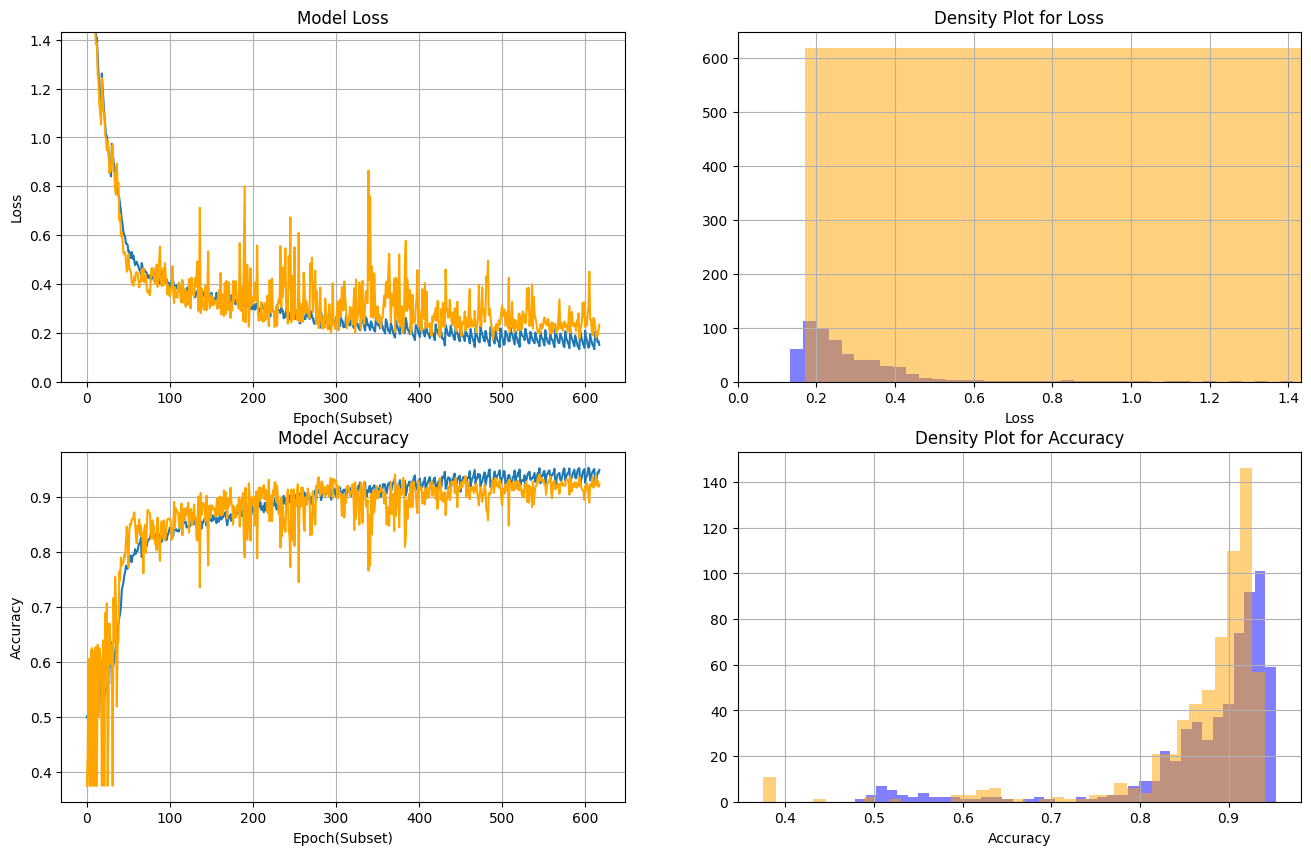

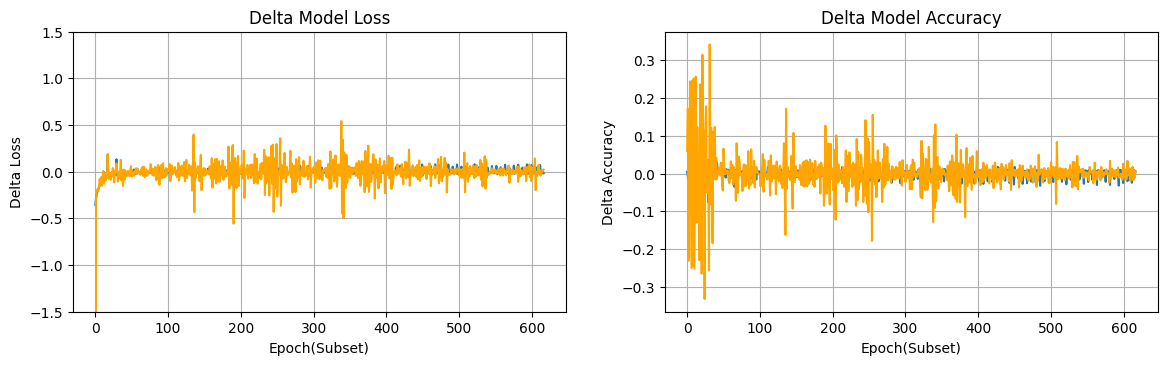

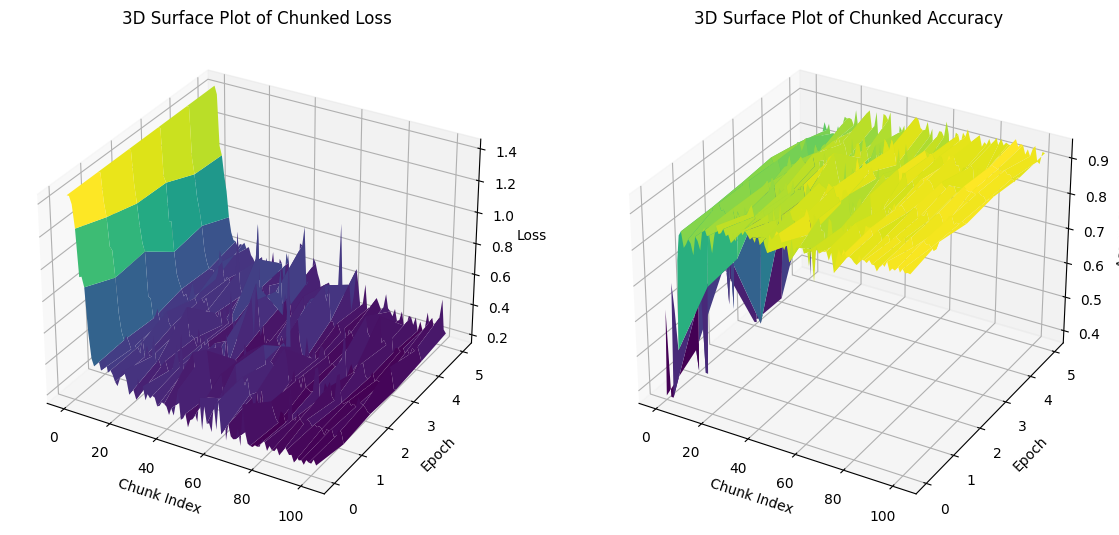

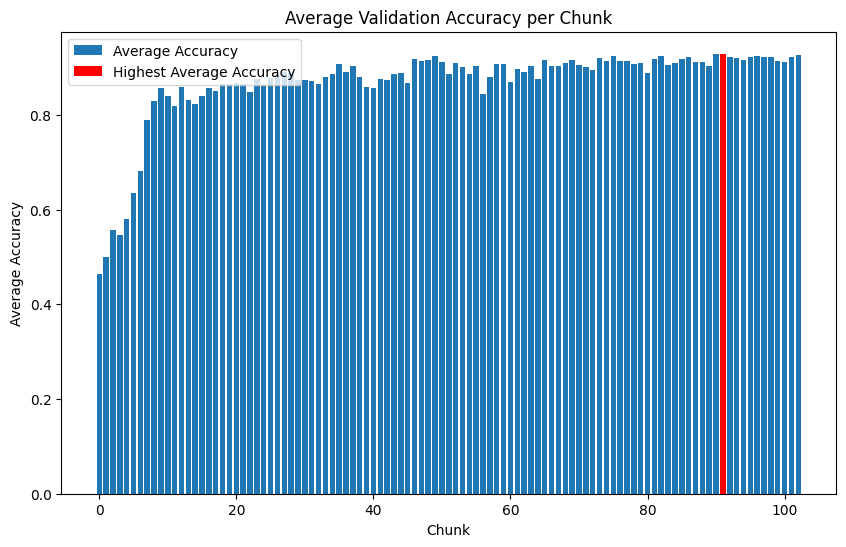

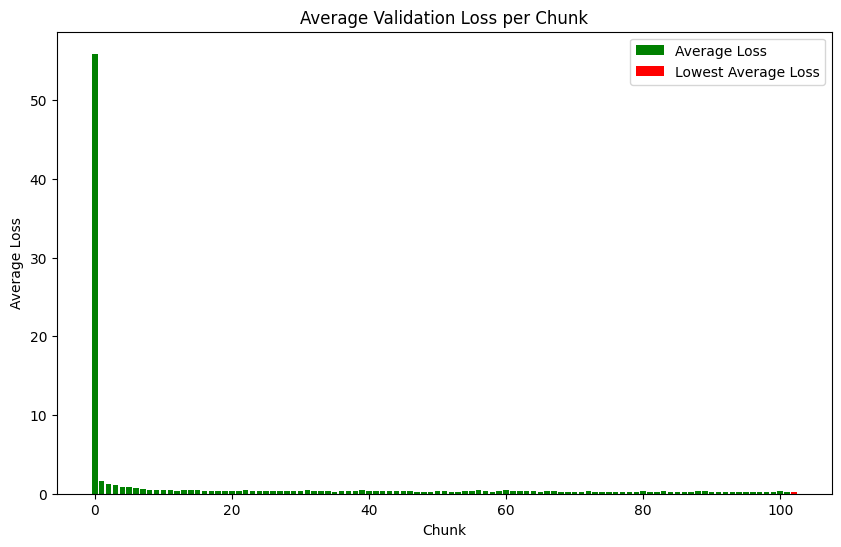

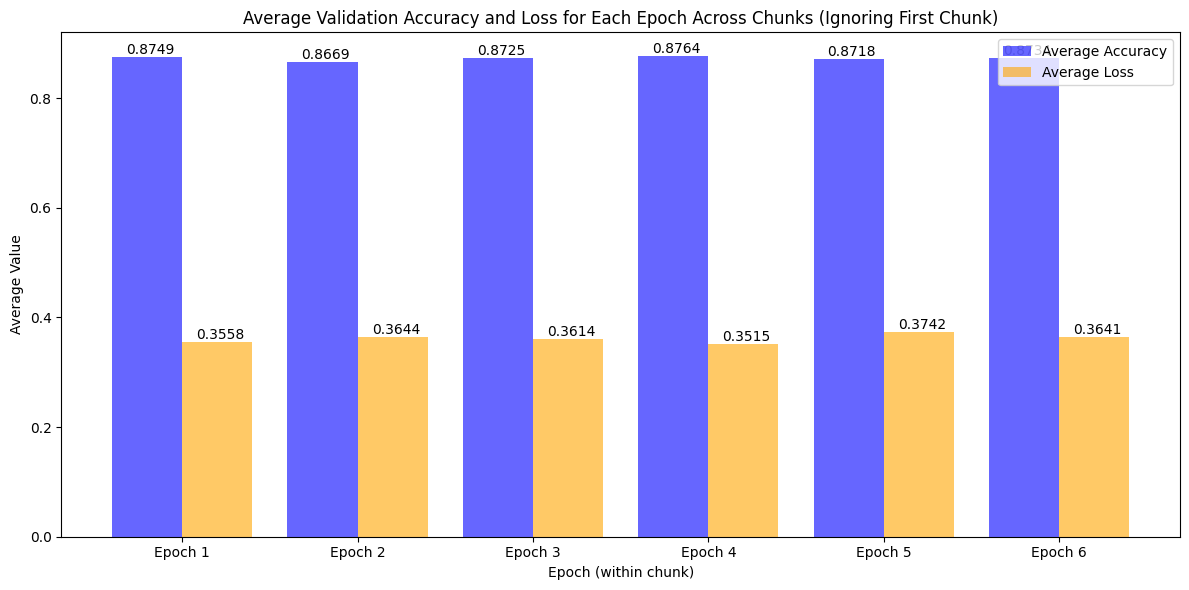

In [10]:
import matplotlib.pyplot as plt

# Chunk size for 3D plot
chunk_size = 6  # Change this to your desired chunk size


def convert_history(history):
    if isinstance(history, tf.keras.callbacks.History):
        return history.history
    else:
        return history


def chunked_data(data, chunk_size):
    return [data[i : i + chunk_size] for i in range(0, len(data), chunk_size)]


try:
    EPM = "Epoch(Subset)" if not isinstance(history, tf.keras.callbacks.History) else "Epoch"
    history = convert_history(history)

    # Calculate deltas
    delta_loss = np.diff(history["loss"])
    delta_accuracy = np.diff(history["accuracy"])

    try:
        delta_val_loss = np.diff(history["val_loss"])
        delta_val_accuracy = np.diff(history["val_accuracy"])
    except (ValueError, NameError):
        print("\033[91mfailed to load val_loss or val_accuracy for delta calculation.")

    plt.figure(figsize=(16, 10))
    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history["loss"], label="loss")
    try:
        plt.plot(history["val_loss"], label="val_loss", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load val_loss.")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel(EPM)
    plt.ylim(top=max(history["val_loss"][10:]), bottom=0)  # (max(history['val_loss'][8:]) + min(history['val_loss'])) / 2
    plt.grid(True)

    # Density plot for loss
    plt.subplot(2, 2, 2)
    plt.hist(history["loss"], label="loss density", color="blue", alpha=0.5, bins=100)
    try:
        plt.hist(
            history["val_loss"],
            label="val_loss density",
            color="orange",
            alpha=0.5,
            bins=100,
        )
    except (ValueError, NameError):
        print("\033[91mfailed to load val_loss (density plot).")
    plt.title("Density Plot for Loss")
    plt.xlabel("Loss")
    plt.xlim(right=max(history["val_loss"][10:]), left=0)  # (max(history['val_loss'][8:]) + min(history['val_loss'])) / 2
    plt.grid(True)

    # Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history["accuracy"], label="accuracy")
    try:
        plt.plot(history["val_accuracy"], label="val_accuracy", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load val_accuracy.")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel(EPM)
    plt.grid(True)

    # Density plot for accuracy
    plt.subplot(2, 2, 4)
    plt.hist(history["accuracy"], label="accuracy density", color="blue", alpha=0.5, bins=40)
    try:
        plt.hist(
            history["val_accuracy"],
            label="val_accuracy density",
            color="orange",
            alpha=0.5,
            bins=40,
        )
    except (ValueError, NameError):
        print("\033[91mfailed to load val_accuracy (density plot).")
    plt.title("Density Plot for Accuracy")
    plt.xlabel("Accuracy")
    plt.grid(True)

    # Delta Loss
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    plt.plot(delta_loss, label="delta_loss")
    try:
        plt.plot(delta_val_loss, label="delta_val_loss", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load delta_val_loss.")
    plt.title("Delta Model Loss")
    plt.ylabel("Delta Loss")
    plt.ylim(top=1.5, bottom=-1.5)
    plt.xlabel(EPM)
    plt.grid(True)
    # Delta Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(delta_accuracy, label="delta_accuracy")
    try:
        plt.plot(delta_val_accuracy, label="delta_val_accuracy", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load delta_val_accuracy.")
    plt.title("Delta Model Accuracy")
    plt.ylabel("Delta Accuracy")
    plt.xlabel(EPM)
    plt.grid(True)

    # Calculate chunked data
    chunked_loss = chunked_data(history["val_loss"], chunk_size)
    chunked_accuracy = chunked_data(history["val_accuracy"], chunk_size)

    # Clip the loss values to a maximum of max(history['val_loss'][10:])
    max_loss = max(history["val_loss"][10:])
    chunked_loss = np.clip(chunked_loss, a_min=None, a_max=max_loss)

    # Create 3D surface plots for each chunk
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121, projection="3d")
    X = np.arange(len(chunked_loss))
    Y = np.arange(chunk_size)
    X, Y = np.meshgrid(X, Y)
    Z = np.array(chunked_loss).T  # Transpose the array to match the shape of X and Y
    ax.plot_surface(X, Y, Z, cmap="viridis")
    ax.set_title("3D Surface Plot of Chunked Loss")
    ax.set_xlabel("Chunk Index")
    ax.set_ylabel("Epoch")
    ax.set_zlabel("Loss")

    ax = fig.add_subplot(122, projection="3d")
    X = np.arange(len(chunked_accuracy))
    Y = np.arange(chunk_size)
    X, Y = np.meshgrid(X, Y)
    Z = np.array(chunked_accuracy).T  # Transpose the array to match the shape of X and Y
    ax.plot_surface(X, Y, Z, cmap="viridis")
    ax.set_title("3D Surface Plot of Chunked Accuracy")
    ax.set_xlabel("Chunk Index")
    ax.set_ylabel("Epoch")
    ax.set_zlabel("Accuracy")

    # Function to calculate the average of chunks
    def chunked_average(values, chunk_size):
        return [np.mean(values[i : i + chunk_size]) for i in range(0, len(values), chunk_size)]

    avg_accuracy_chunks = chunked_average(history["val_accuracy"], chunk_size)
    avg_loss_chunks = chunked_average(history["val_loss"], chunk_size)

    # Find the chunk with the highest average accuracy
    Acc_max_acc_chunk_index = np.argmax(avg_accuracy_chunks)
    max_acc_value = avg_accuracy_chunks[Acc_max_acc_chunk_index]
    
    # Find the chunk with the lowest average loss
    Loss_max_acc_chunk_index = np.argmin(avg_loss_chunks)
    min_loss_value = avg_loss_chunks[Loss_max_acc_chunk_index]

    # Create a pile plot for accuracy
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(avg_accuracy_chunks)), avg_accuracy_chunks, label="Average Accuracy")
    plt.bar(
        Acc_max_acc_chunk_index,
        max_acc_value,
        color="red",
        label="Highest Average Accuracy",
    )
    plt.xlabel("Chunk")
    plt.ylabel("Average Accuracy")
    plt.title("Average Validation Accuracy per Chunk")
    plt.legend()

    # Create a pile plot for loss
    plt.figure(figsize=(10, 6))
    plt.bar(
        range(len(avg_loss_chunks)),
        avg_loss_chunks,
        color="green",
        label="Average Loss",
    )
    plt.bar(
        Loss_max_acc_chunk_index,
        min_loss_value,
        color="red",
        label="Lowest Average Loss",
    )
    plt.xlabel("Chunk")
    plt.ylabel("Average Loss")
    plt.title("Average Validation Loss per Chunk")
    plt.legend()

    # Function to calculate the average of each epoch across chunks, ignoring the first chunk
    def average_across_chunks(values, chunk_size):
        num_chunks = len(values) // chunk_size
        avg_values = []
        for epoch in range(chunk_size):
            epoch_values = [values[chunk * chunk_size + epoch] for chunk in range(1, num_chunks)]
            avg_values.append(np.mean(epoch_values))
        return avg_values

    # Calculate the average accuracy and loss for each epoch across chunks, ignoring the first chunk
    avg_accuracy_epochs = average_across_chunks(history["val_accuracy"], chunk_size)
    avg_loss_epochs = average_across_chunks(history["val_loss"], chunk_size)

    # Create a bar plot for average accuracy and loss of each epoch across chunks
    plt.figure(figsize=(12, 6))

    # Create an index for each epoch
    epoch_indices = np.arange(len(avg_accuracy_epochs))

    bars1 = plt.bar(
        epoch_indices - 0.2,
        avg_accuracy_epochs,
        width=0.4,
        label="Average Accuracy",
        color="blue",
        alpha=0.6,
    )
    bars2 = plt.bar(
        epoch_indices + 0.2,
        avg_loss_epochs,
        width=0.4,
        label="Average Loss",
        color="orange",
        alpha=0.6,
    )

    # Add labels and title
    plt.xlabel("Epoch (within chunk)")
    plt.ylabel("Average Value")
    plt.title("Average Validation Accuracy and Loss for Each Epoch Across Chunks (Ignoring First Chunk)")
    plt.xticks(epoch_indices, [f"Epoch {i + 1}" for i in epoch_indices])  # Set x-tick labels to epoch numbers

    # Adding the numbers on the bars
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/5.0, yval, round(yval, 4), va='bottom') # va: vertical alignment

    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/5.0, yval, round(yval, 4), va='bottom')

    plt.legend()
    plt.tight_layout()
    plt.show()

except (ValueError, NameError) as E:
    print(f"\033[91mFailed to load model history.\nError: {E}")

## Analyse model Predicting performance

In [ ]:
import traceback
import gc

# Garbage Collection (memory)
gc.collect()

Extra_EXT = "_T"  # _T or _T_BL
Train_data_test = False
if SAVE_TYPE == "TF":
    # Load the pre-trained model
    model = load_model(f"PAI_model{Extra_EXT}")
else:
    # Load the pre-trained model
    model = load_model(f"PAI_model{Extra_EXT}.h5")

# Ensure the model's input_shape matches your data
assert model.input_shape[1:] == (
    img_res[0],
    img_res[1],
    img_res[2],
), "Models input shape doesnt match data."

# Make predictions on validation data
val_predictions = model.predict(x_val)

# Make predictions on test data
test_predictions = model.predict(x_test)

# Print acc
print("Val data acc:")
evaluate_model_full(y_val, val_predictions)  # noqa: F405
print("Test data acc:")
evaluate_model_full(y_test, test_predictions)  # noqa: F405

# format data
val_predictions = np.argmax(val_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
y_val_original = np.argmax(y_val, axis=1)
y_test_original = np.argmax(y_test, axis=1)
# Visualize the predictions on validation data as a grid of squares
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_val[i])
    plt.title(f"True: {y_val_original[i]}\nPredicted: {val_predictions[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
# Heatmap
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = x_val[i]
    heatmap = make_gradcam_heatmap(
        img[np.newaxis, ...],
        model,
        "top_activation",
        second_last_conv_layer_name="top_conv",
        sensitivity_map=1,
    )
    heatmap = cv2.resize(np.clip(heatmap, 0, 1), (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    if RANGE_NOM:
        superimposed_img = (heatmap / 255) * 0.4 + (img * 0.6)
    else:
        superimposed_img = (heatmap / 255) * 0.4 + ((img / 255) * 0.6)
    # clip
    superimposed_img = np.clip(superimposed_img, 0, 1)  # ensure the values are in the range [0, 1]
    plt.imshow(superimposed_img)
    plt.title(f"True: {y_val_original[i]}\nPredicted: {val_predictions[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Define the list of labels
labels = ["NORMAL", "PNEUMONIA"]

# Create a confusion matrix for validation data
val_cm = confusion_matrix(y_val_original, val_predictions)

# Create a confusion matrix for test data
test_cm = confusion_matrix(y_test_original, test_predictions)

# Plot the confusion matrix as a heatmap for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Validation Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot the confusion matrix as a heatmap for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Define the range of test data sizes to use
data_sizes = range(1, len(x_test), 4)

# Create a list to store the number of incorrect predictions for each test data size
incorrect_predictions = []

# Generate predictions and track incorrect predictions for each data size
for size in tqdm(data_sizes, desc="Predicting", unit="dpb"):
    if traceback.format_exc() == "":
        break
    # Garbage Collection (memory)
    gc.collect()
    # Randomly select a subset of test data
    indices = np.random.choice(len(x_test), size, replace=False)
    x_test_subset = x_test[indices]
    y_test_subset = y_test[indices]

    # Make predictions on the subset of test data
    test_predictions = model.predict(
        x_test_subset,
        batch_size=1,
        verbose=0,
        max_queue_size=120,
        workers=1,
        use_multiprocessing=False,
    )
    test_predictions = np.argmax(test_predictions, axis=1)
    y_test_original_subset = np.argmax(y_test_subset, axis=1)

    # Calculate the number of incorrect predictions
    incorrect_preds = np.sum(test_predictions != y_test_original_subset)
    incorrect_predictions.append(incorrect_preds)

try:
    # Plot the number of incorrect predictions vs. the number of data points
    plt.figure(figsize=(10, 6))
    plt.plot(data_sizes, incorrect_predictions)
    plt.xlabel("Number of Data Points")
    plt.ylabel("Number of Incorrect Predictions")
    # Add gridlines for the x and y axes
    plt.grid(True)

    # Change the tick spacing for the x and y axes
    plt.xticks(np.arange(min(data_sizes), max(data_sizes) + 1, 50))
    plt.yticks(np.arange(0, max(incorrect_predictions) + 5, 3))

    plt.title("Number of Incorrect Predictions vs. Number of Data Points")
    plt.show()
except Exception:
    P_warning("Failed to plot incorrect predictions vs. data points")  # noqa: F405